In [24]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

import cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

from collections import defaultdict, OrderedDict
import multiprocessing as mp
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from data_types import ase
import plotlib
import toolkit
import util
import test_phasing
from workspace.workspace_manager import WorkspaceManager

workspace = WorkspaceManager(
    task_name="counts_to_ase",
    experiment_info={"data" : "scDNA"},
    verbose=True
)
workspace.load_workspace()

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading workspace

In [25]:
clustering_name = 'evo_dist_9'
requirements = ["raw_counts", "genome", "gene_to_snps", 
                "gene_counts", "clustering"]

data = {
    dtype : 
    util.pickle_load(workspace.tmp_data[dtype])
    for dtype in tqdm_notebook(
        requirements,
        "loading datasets into RAM"
    )
}
data_name = workspace.experiment_info['data']
sample_name = workspace.experiment_info['sample']
print(f"Currently working on {data_name},"
      f"{sample_name}, {clustering_name} clustering")


Currently working on scDNA,first_sample, evo_dist_9 clustering


# ASE ratios of genes on the chromosome 3p

In [26]:
genes_on_3p = [
    "ALAS1", "APEH", "ARPP-21", "AZI2",
    "BRK1", "BRPF1", "BTD", 
    "C3orf14", "C3orf23", "C3orf60", "CACNA2D3", 
    "CCR5", "CGGBP1", "CMTM7", "CNTN4", "COL7A1", "CRBN",
    "DCLK3",
    "ENTPD3", 
    "FAM107A", "FAM19A1", "FBXL2", "FOXP1", "FRA3A", "FRMD4B",
    "GMPPB", 
    "HEMK1", "HIGD1A", 
    "LARS2", "LIMD1", "LINC00312",
    "MITF", "MLH1", "MYRIP", 
    "NBEAL2", "NKTR", "NPRL2", 
    "OXTR", 
    "PHF7", "PTHR1",
    "QRICH1", 
    "RBM6", "RPP14", 
    "SCN5A", "SETD5", "SFMBT1", "SLC25A20", "STT3B", "SYNPR",
    "TDFG1", "TMEM158", "TMIE", "TRAK1", "TRANK1",
    "UCN2", "ULK4", 
    "VGLL3", "VHL", 
    "ZMYND10", "ZNF502", "ZNF621"
]

In [10]:
data["gene_counts"]["GENE_ID"] = data["genome"]["GENE_ID"]

In [27]:
test_phasing.test_deletion_ase_for_genes(
    genes_on_3p,
    data,
    tags={
        "data" : data_name,
        "sample" : sample_name,
        "clustering" : clustering_name
    },
    img_dir=f"{workspace.img_dir}/scDNA"\
            "/phasing_tests/clustering_by_cnv/genes/3p/haplotype_blocks"
)

# ASE ratios of individual SNPs on the chromosome 3p

In [5]:
data["non_merged_genome"] = pd.read_csv(
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference"
    "/data/raw/non_merged_hg19.csv"
)

ALAS1 doesn't intersect phased SNPs
APEH doesn't intersect phased SNPs
ARPP-21 not in index
BRPF1 doesn't intersect phased SNPs
C3orf14 doesn't intersect phased SNPs
C3orf23 not in index
C3orf60 not in index
CGGBP1 doesn't intersect phased SNPs


No handles with labels found to put in legend.


FRA3A not in index
GMPPB doesn't intersect phased SNPs
HEMK1 doesn't intersect phased SNPs


No handles with labels found to put in legend.
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


NPRL2 doesn't intersect phased SNPs
PHF7 doesn't intersect phased SNPs
PTHR1 not in index
QRICH1 doesn't intersect phased SNPs
RBM6 doesn't intersect phased SNPs
RPP14 is ambiguous in hg19
SETD5 doesn't intersect phased SNPs
SLC25A20 doesn't intersect phased SNPs
TDFG1 not in index
TMEM158 doesn't intersect phased SNPs
UCN2 doesn't intersect phased SNPs
ZMYND10 doesn't intersect phased SNPs
ZNF502 doesn't intersect phased SNPs
CPU times: user 17min 12s, sys: 1min 7s, total: 18min 19s
Wall time: 18min 32s


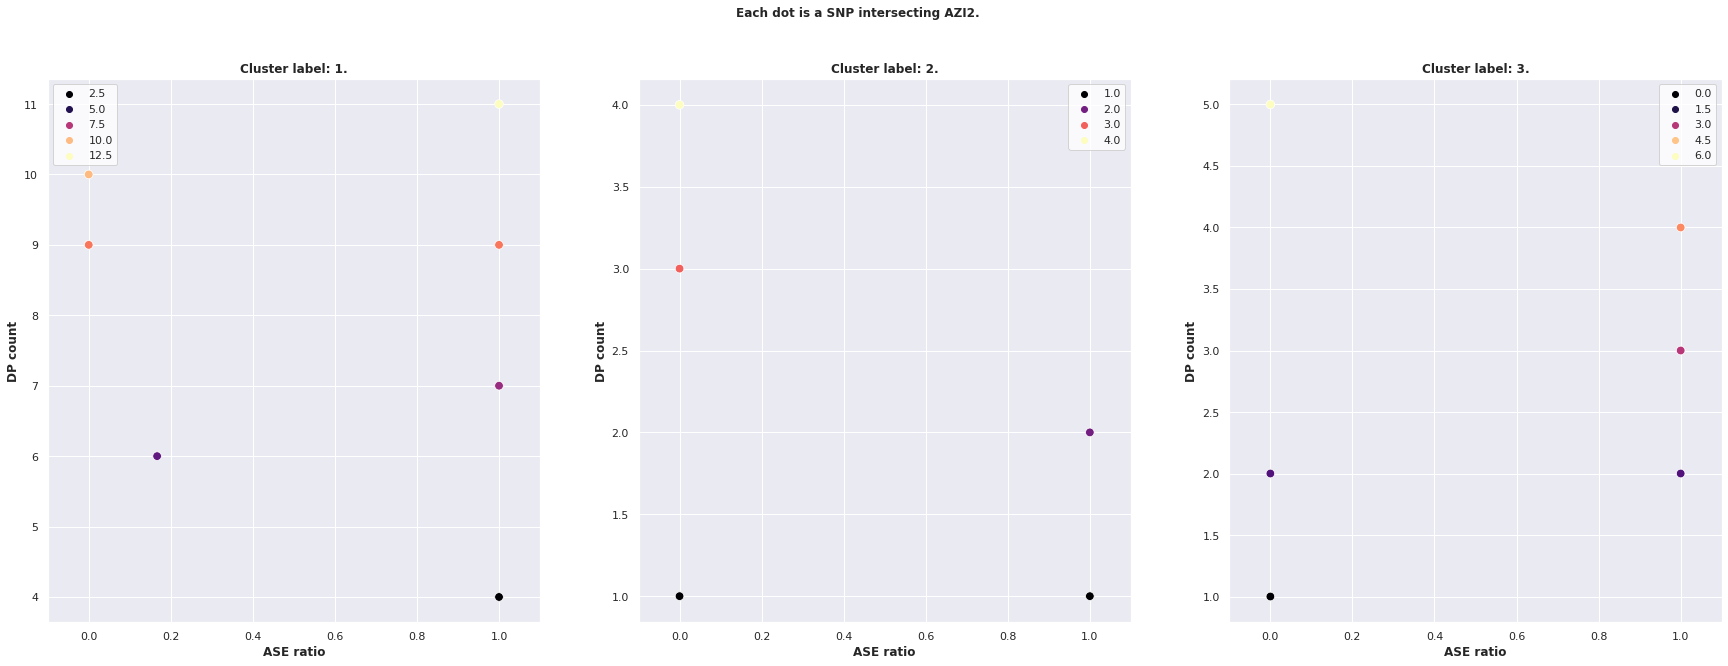

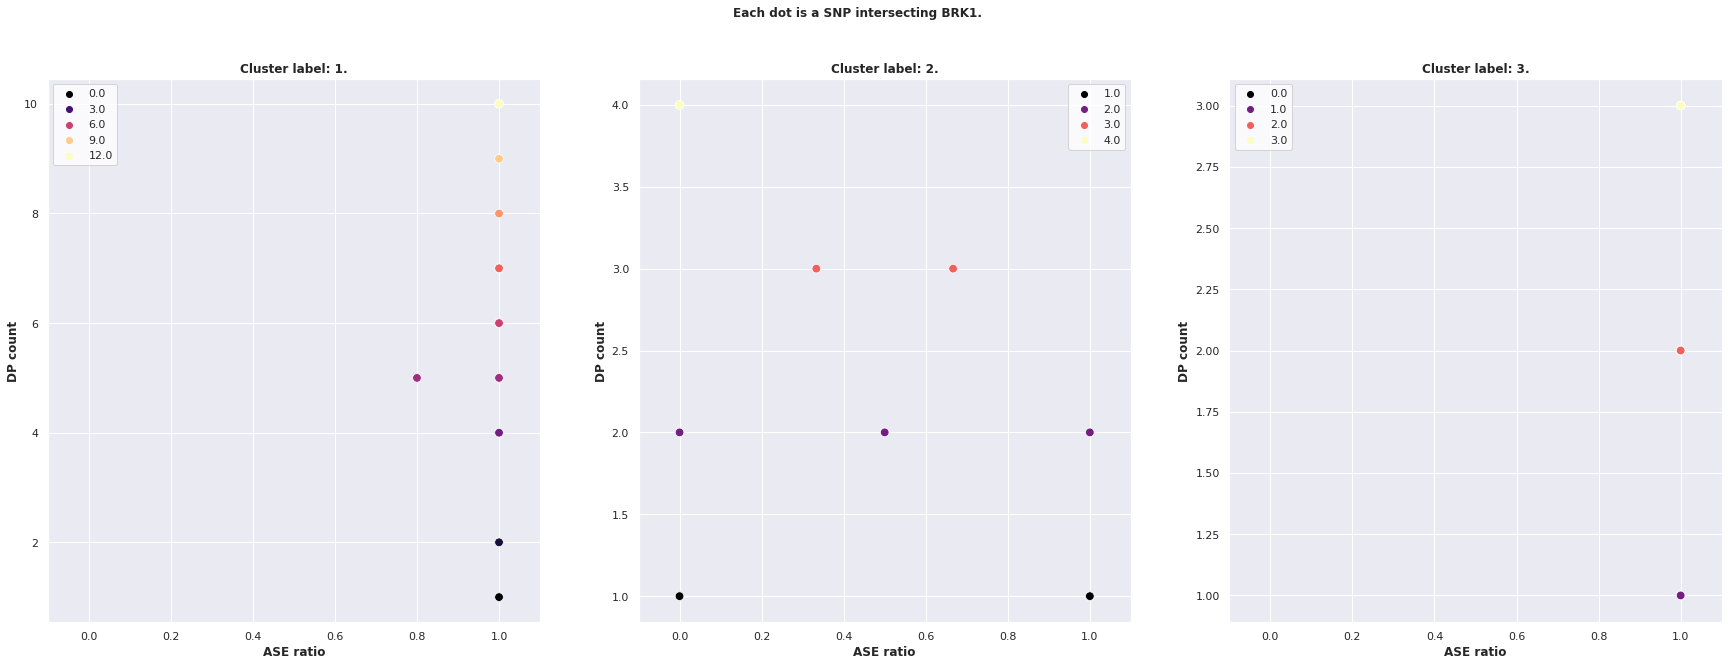

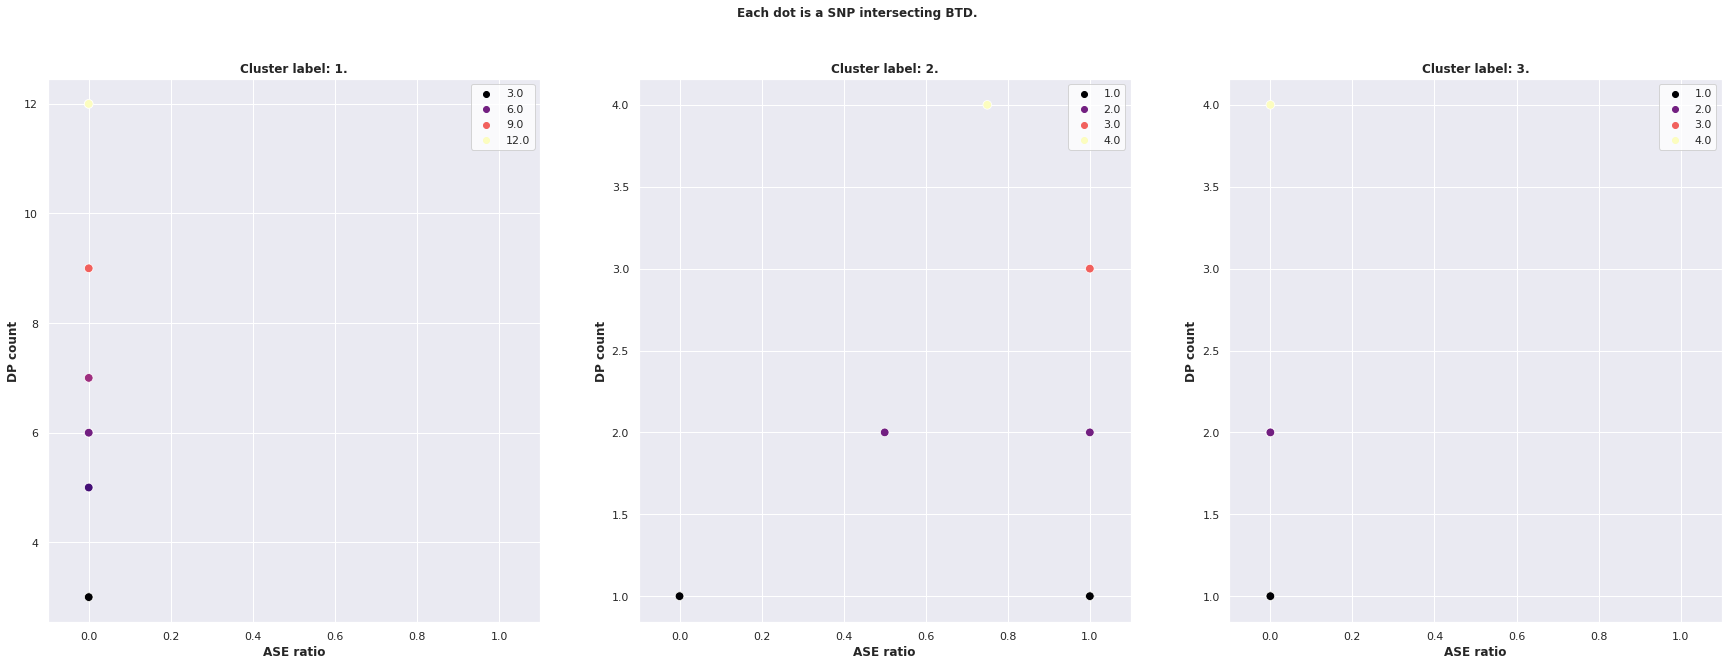

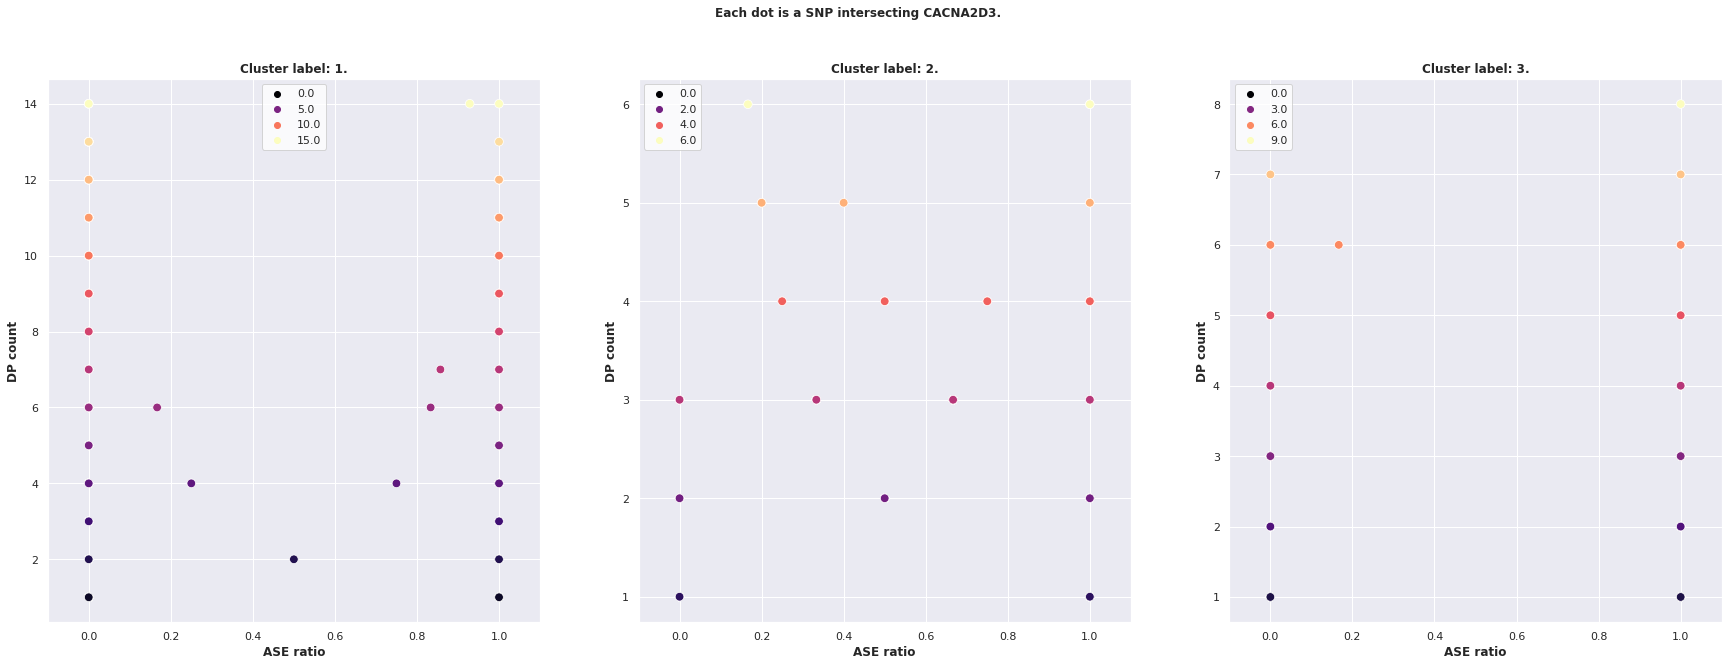

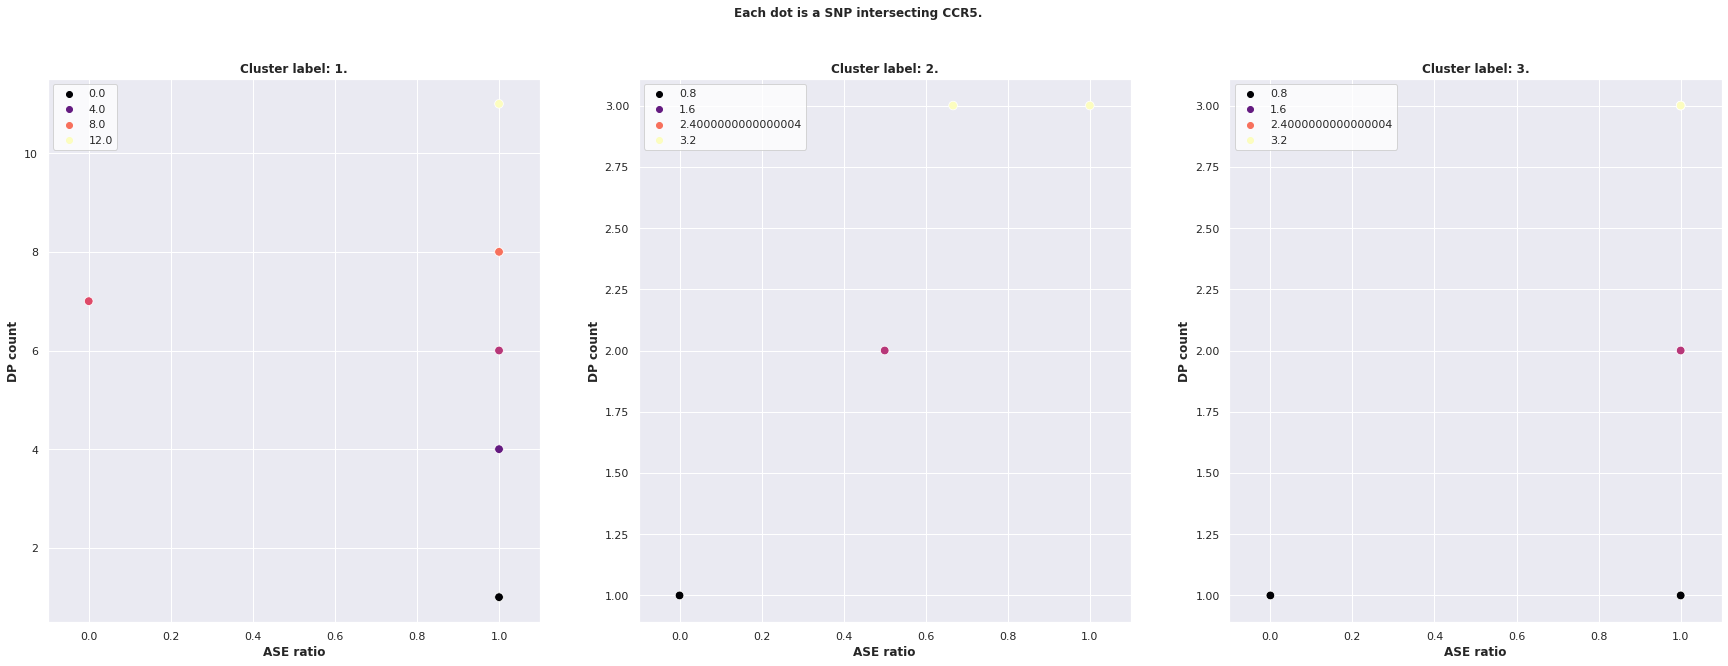

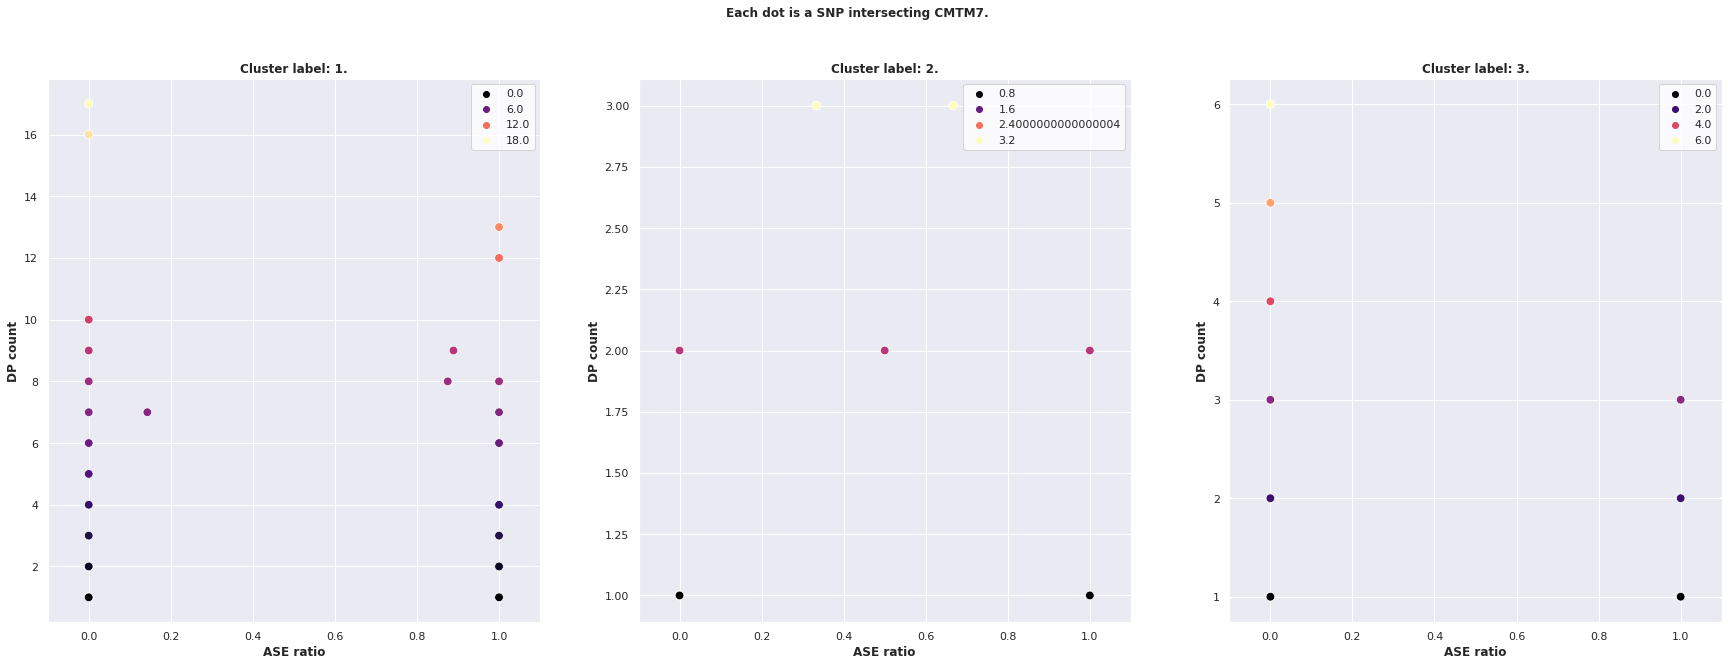

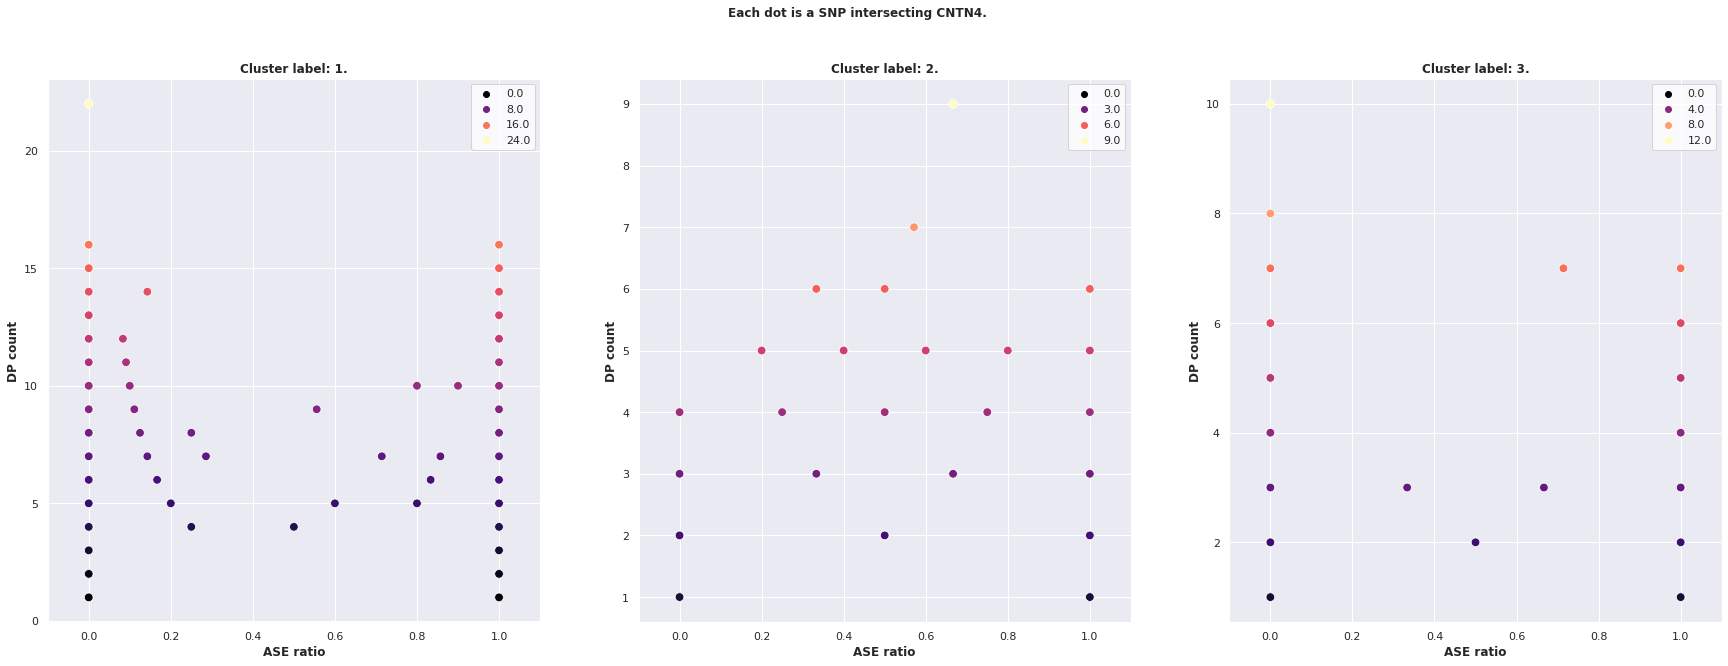

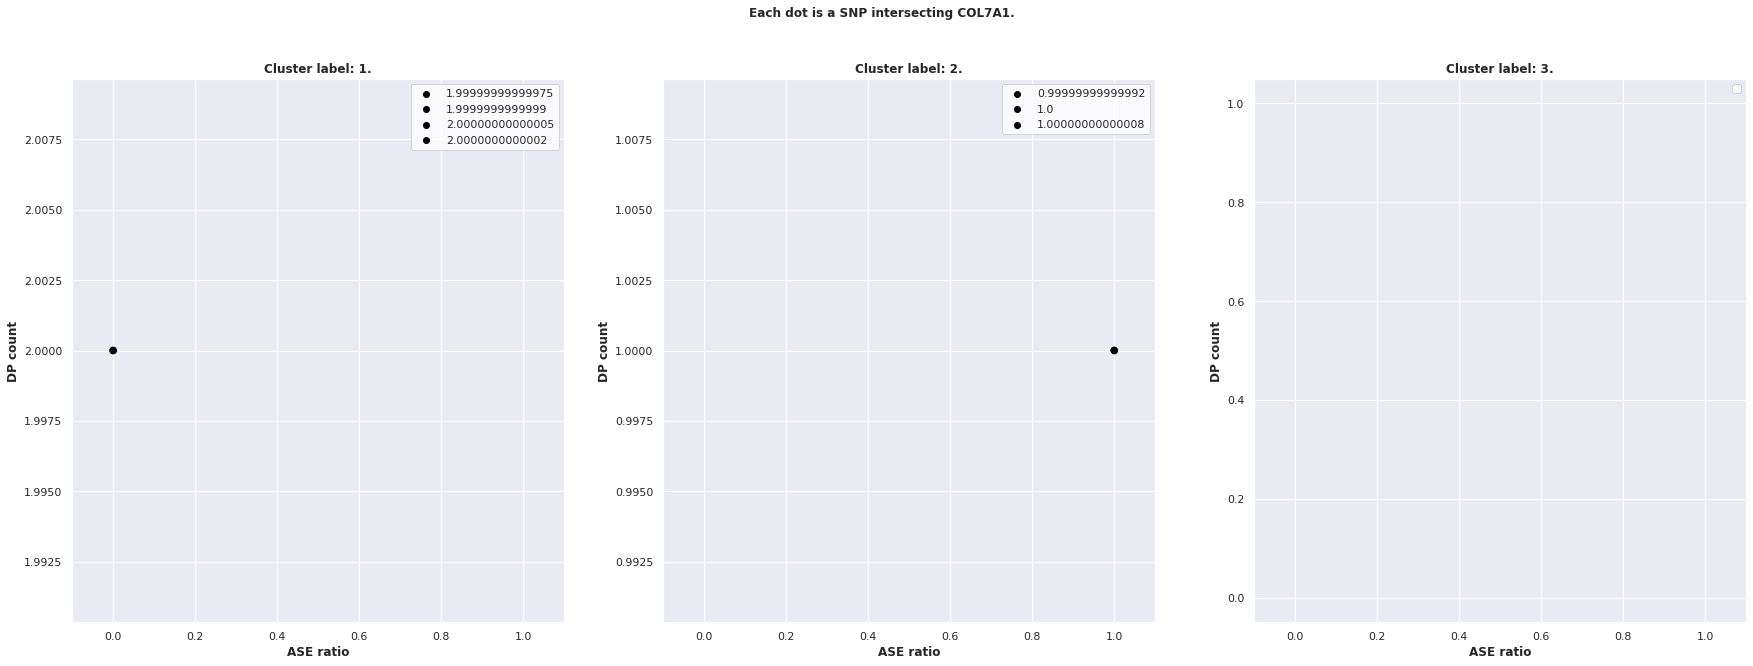

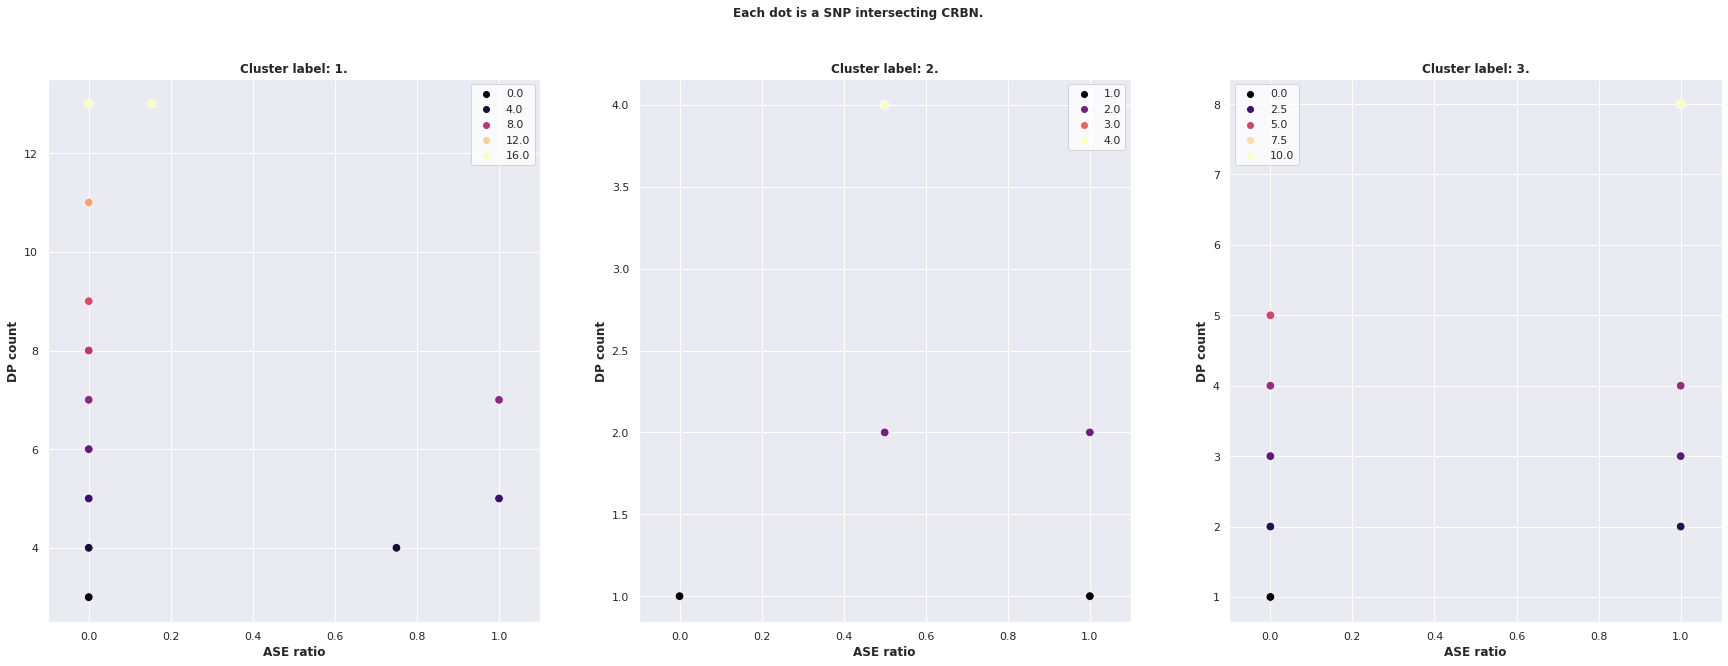

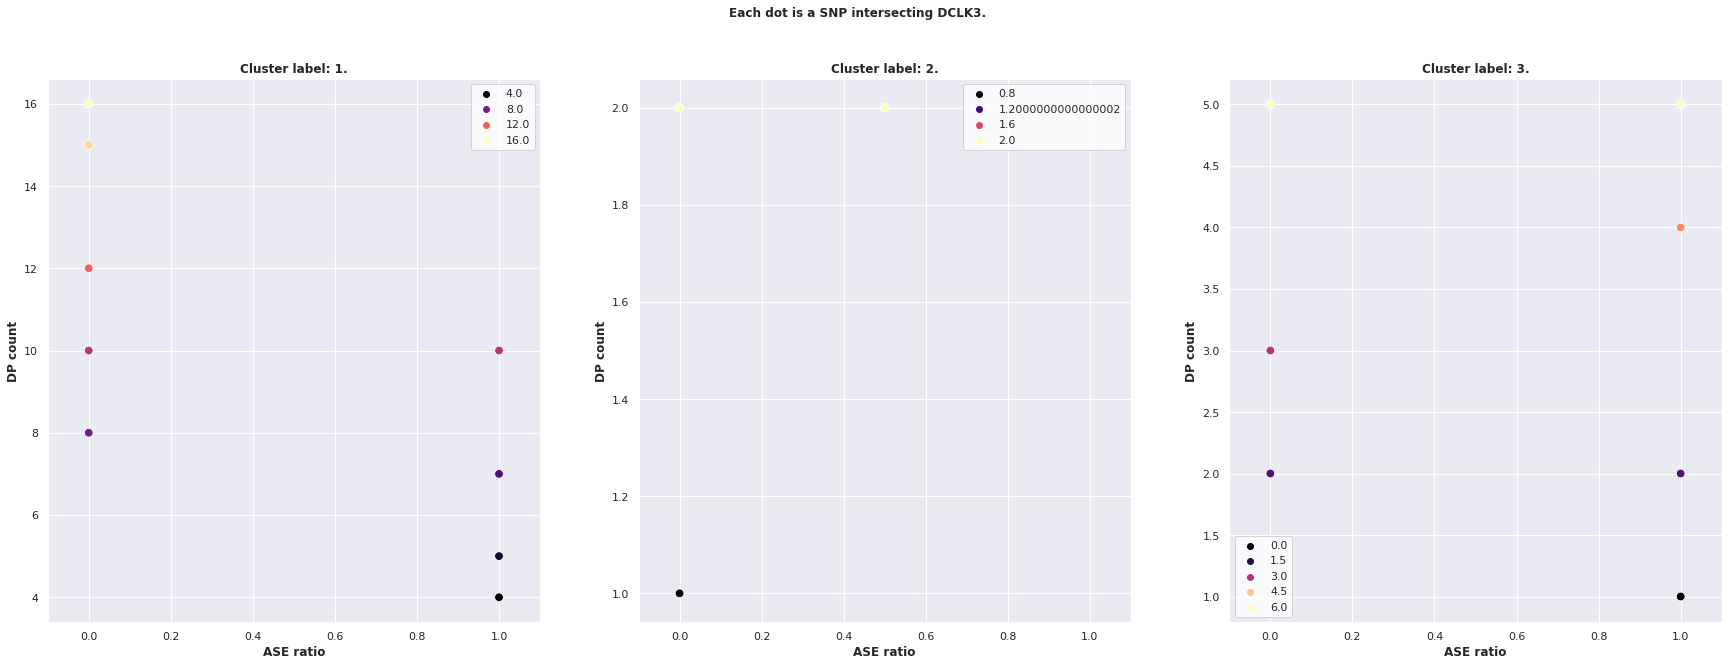

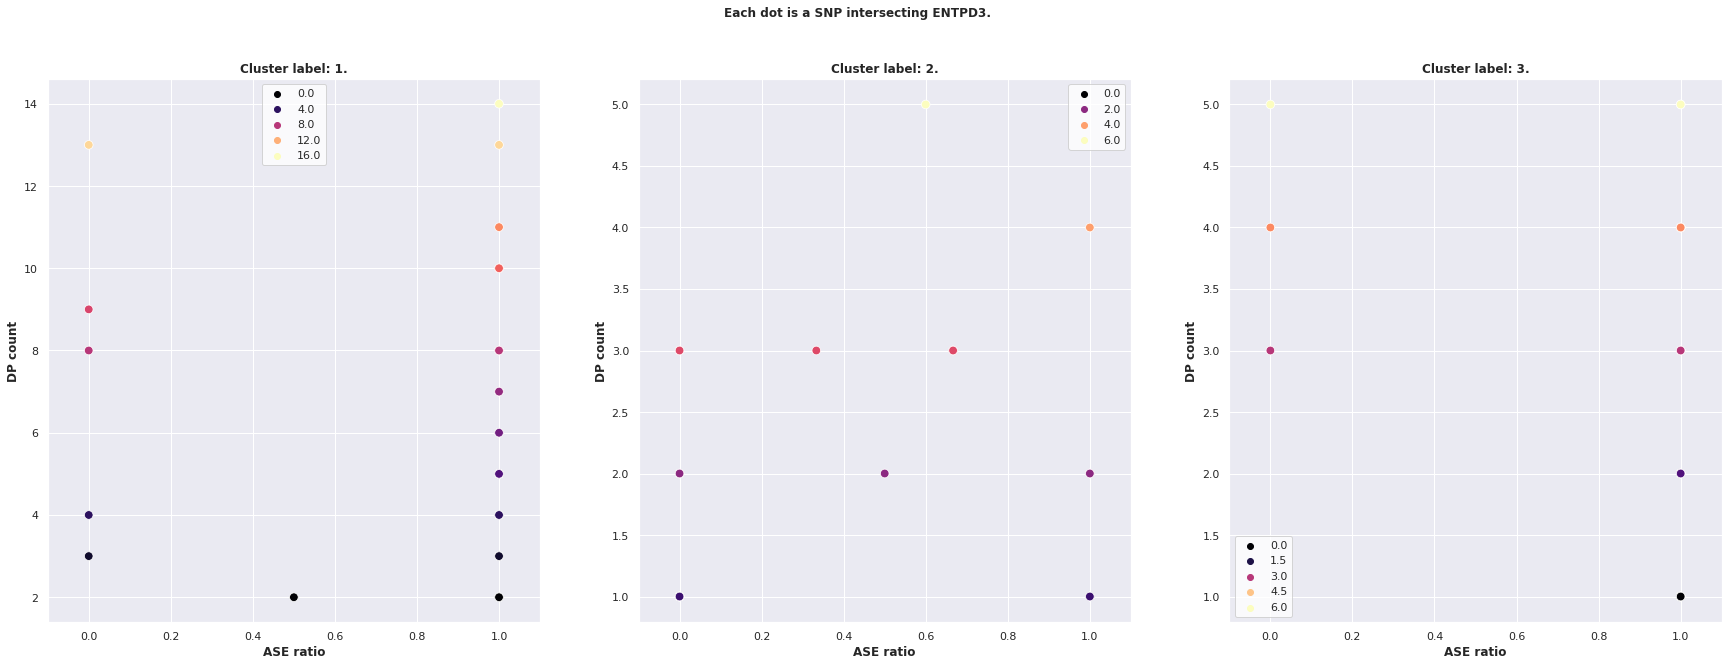

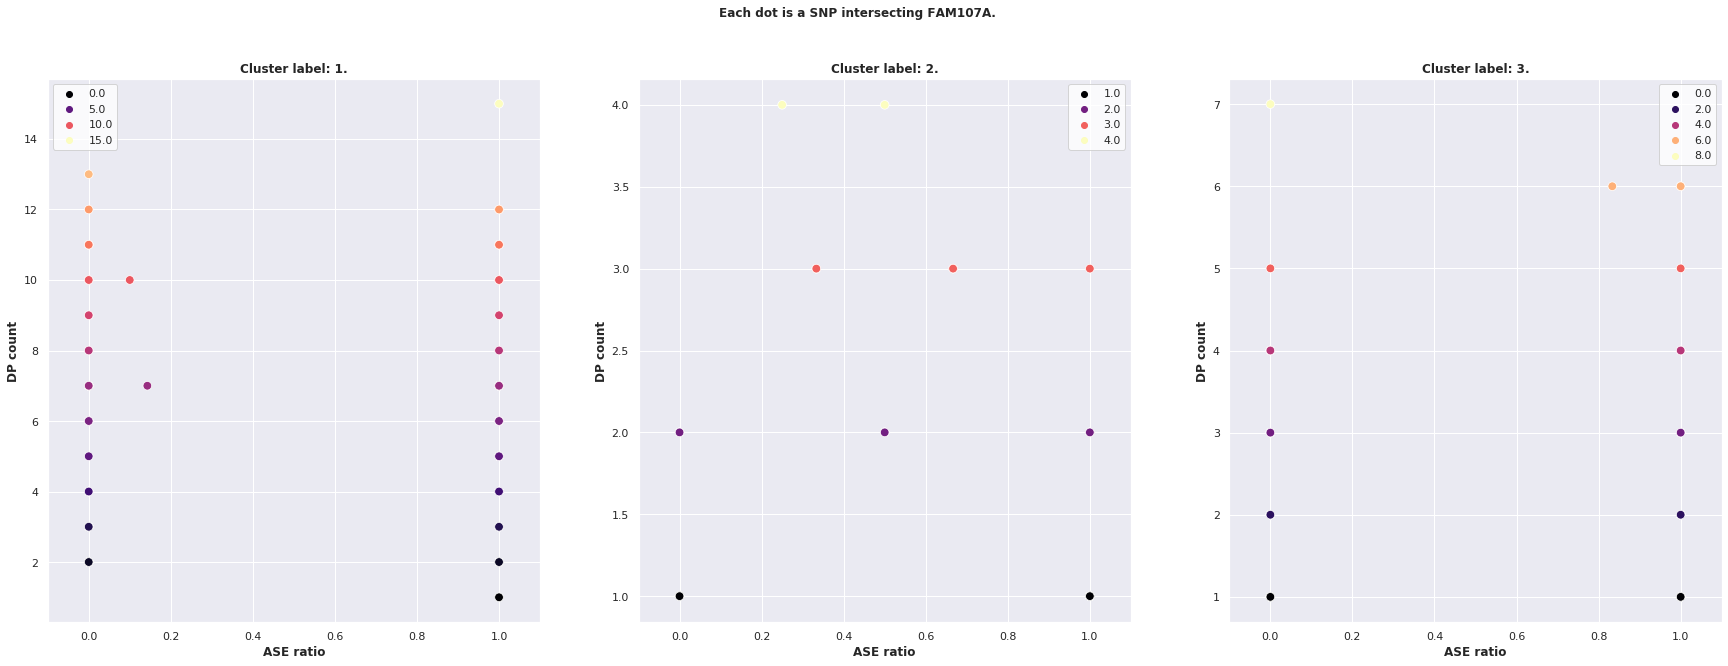

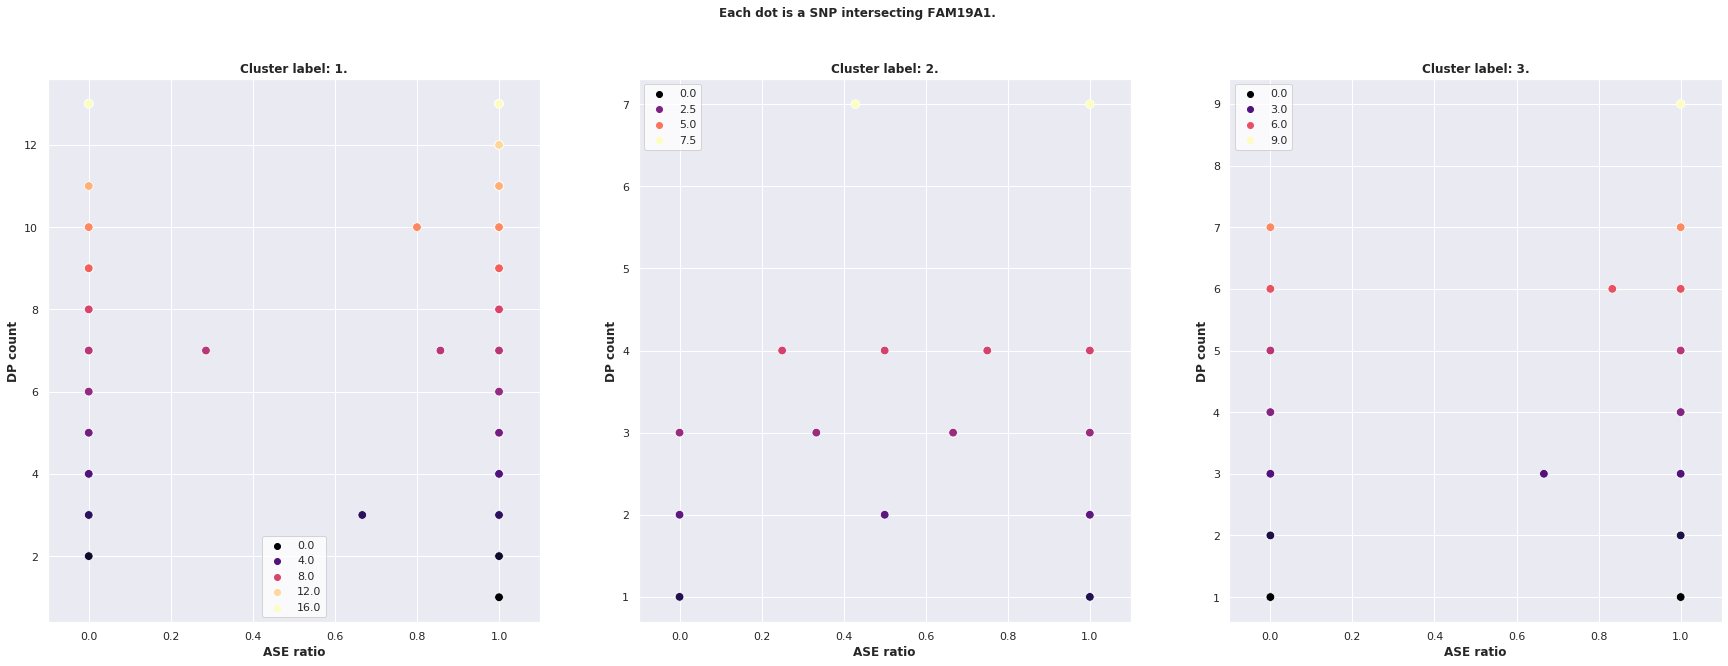

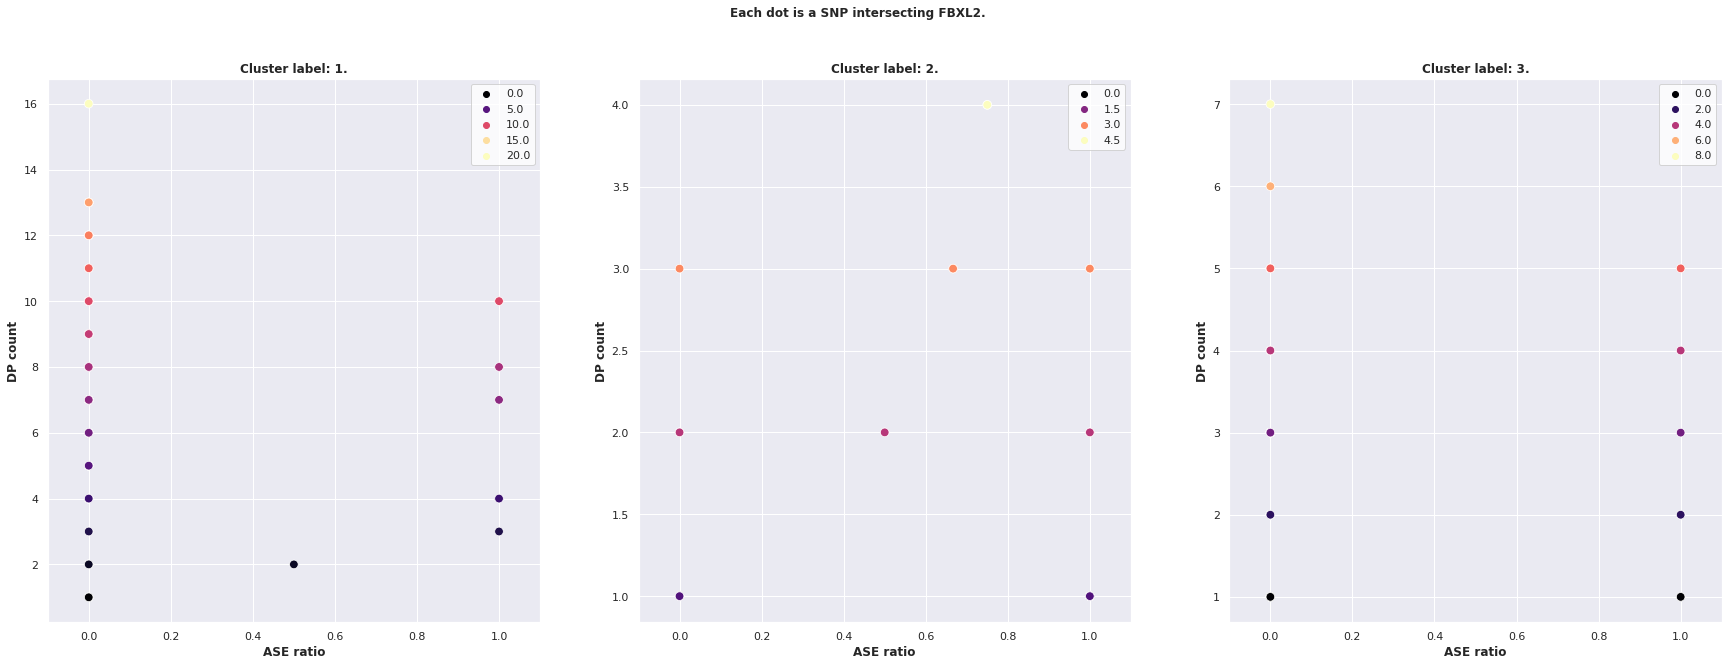

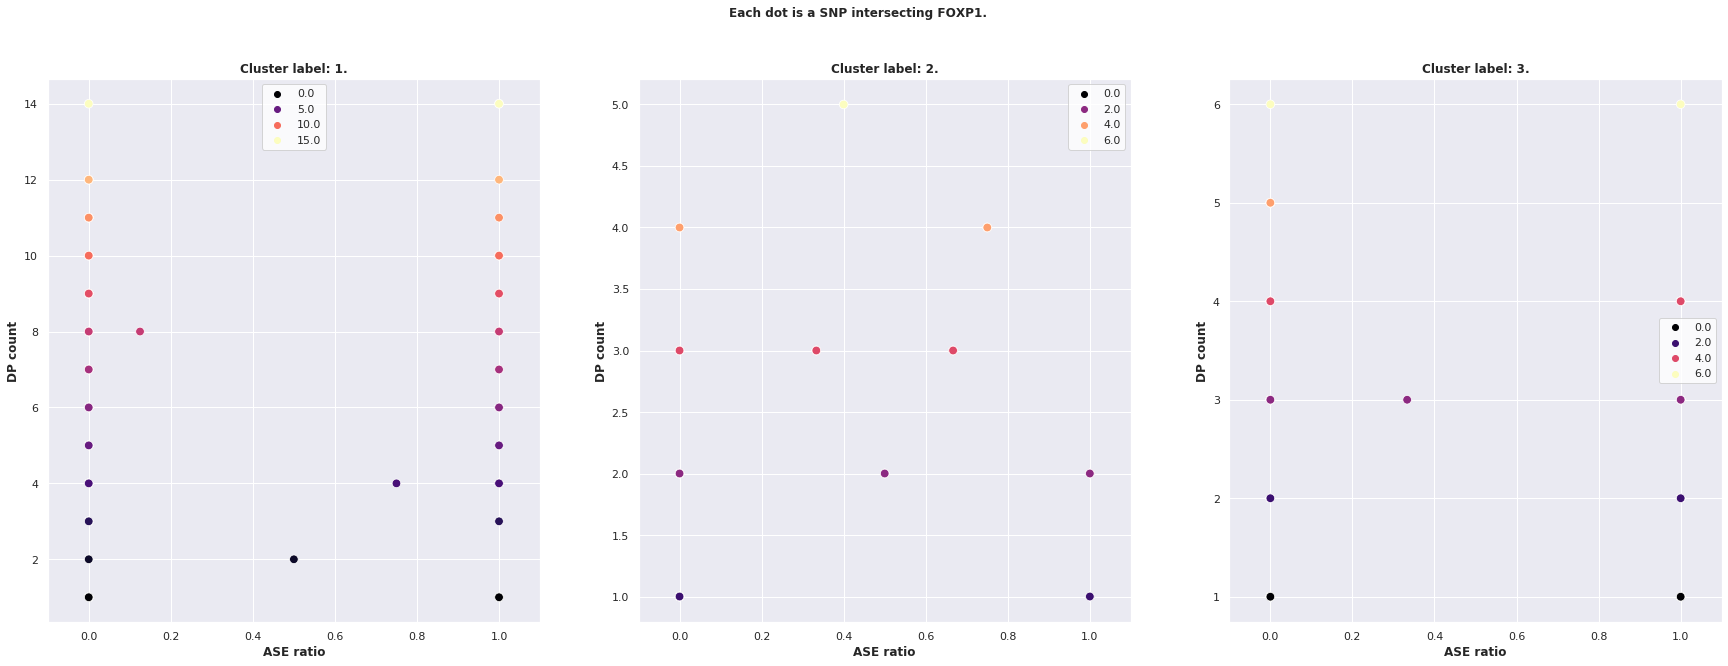

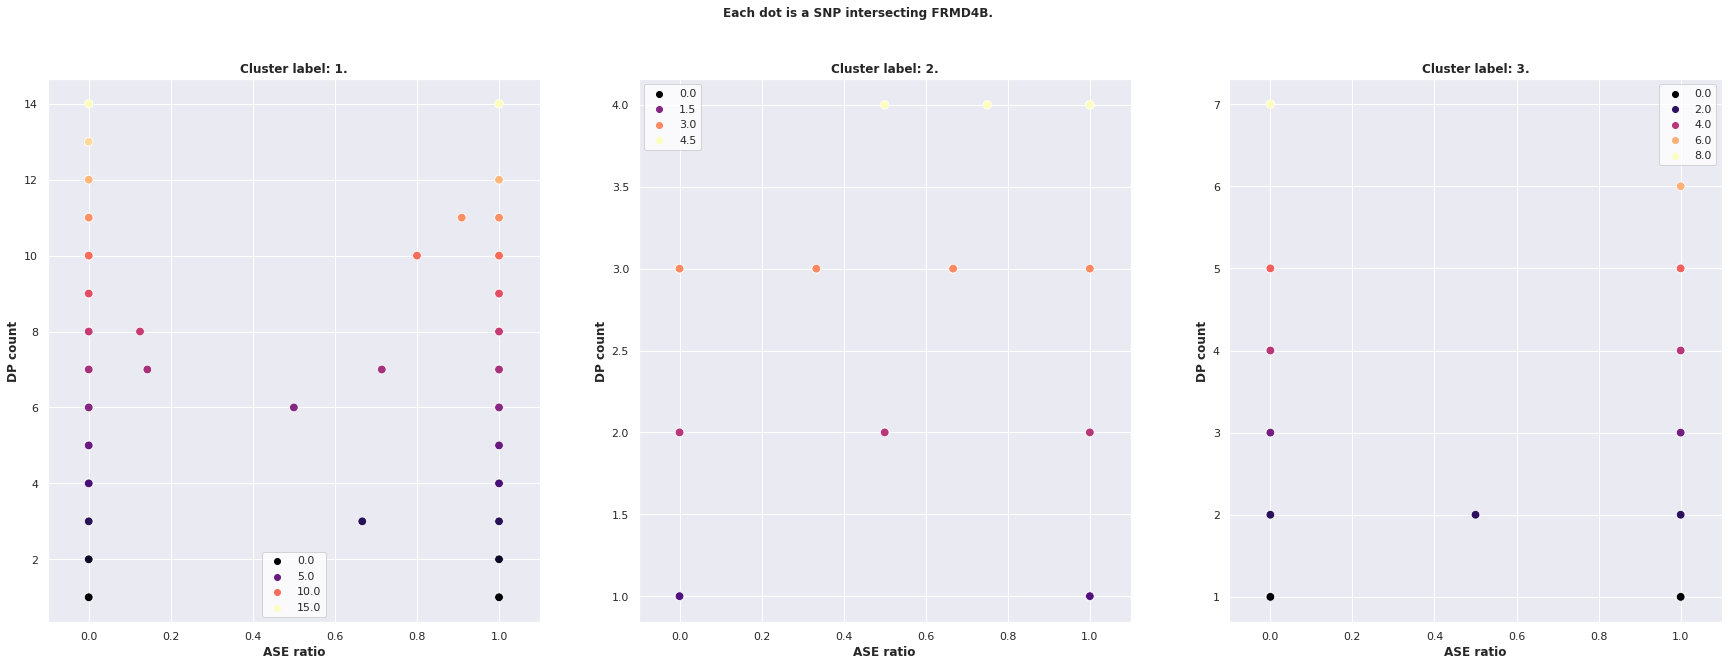

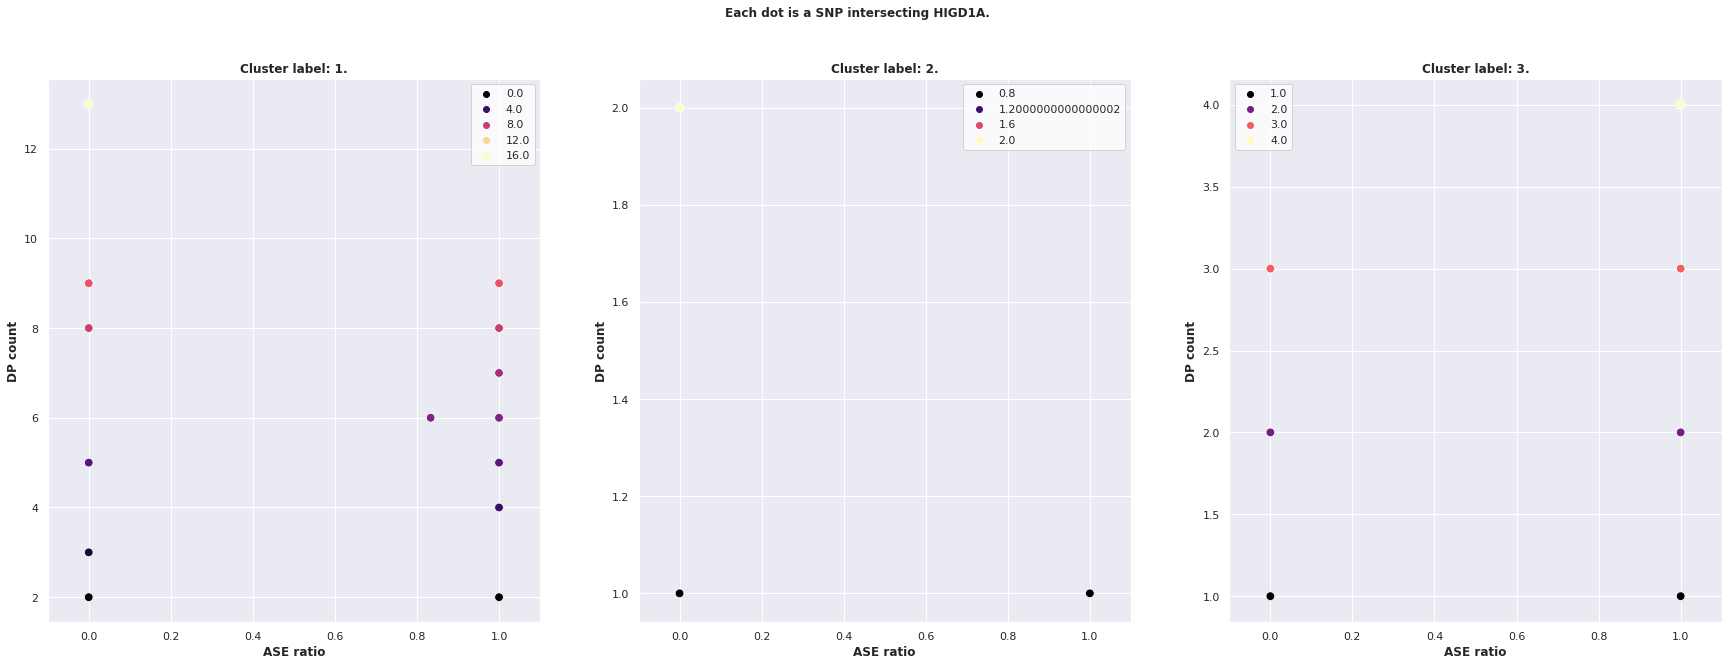

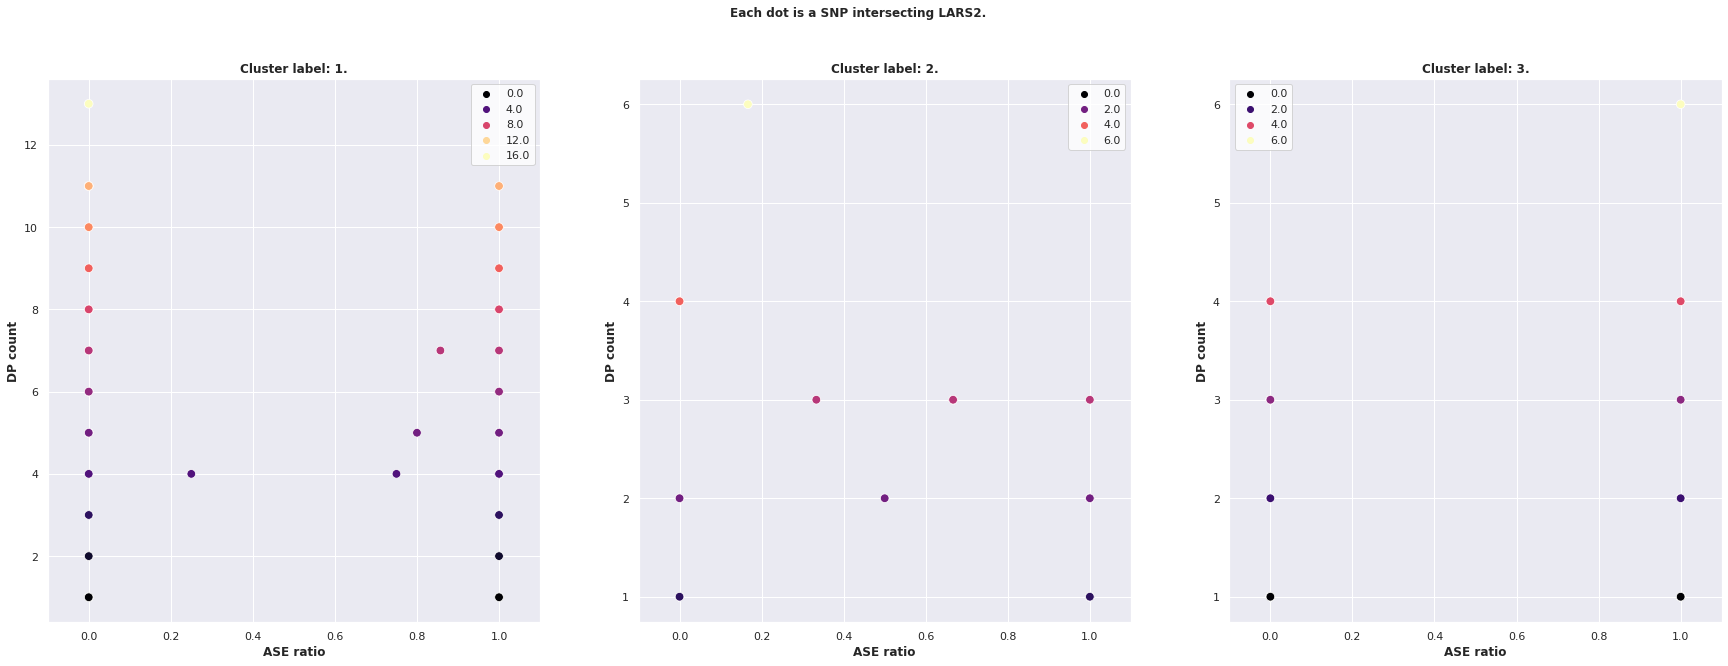

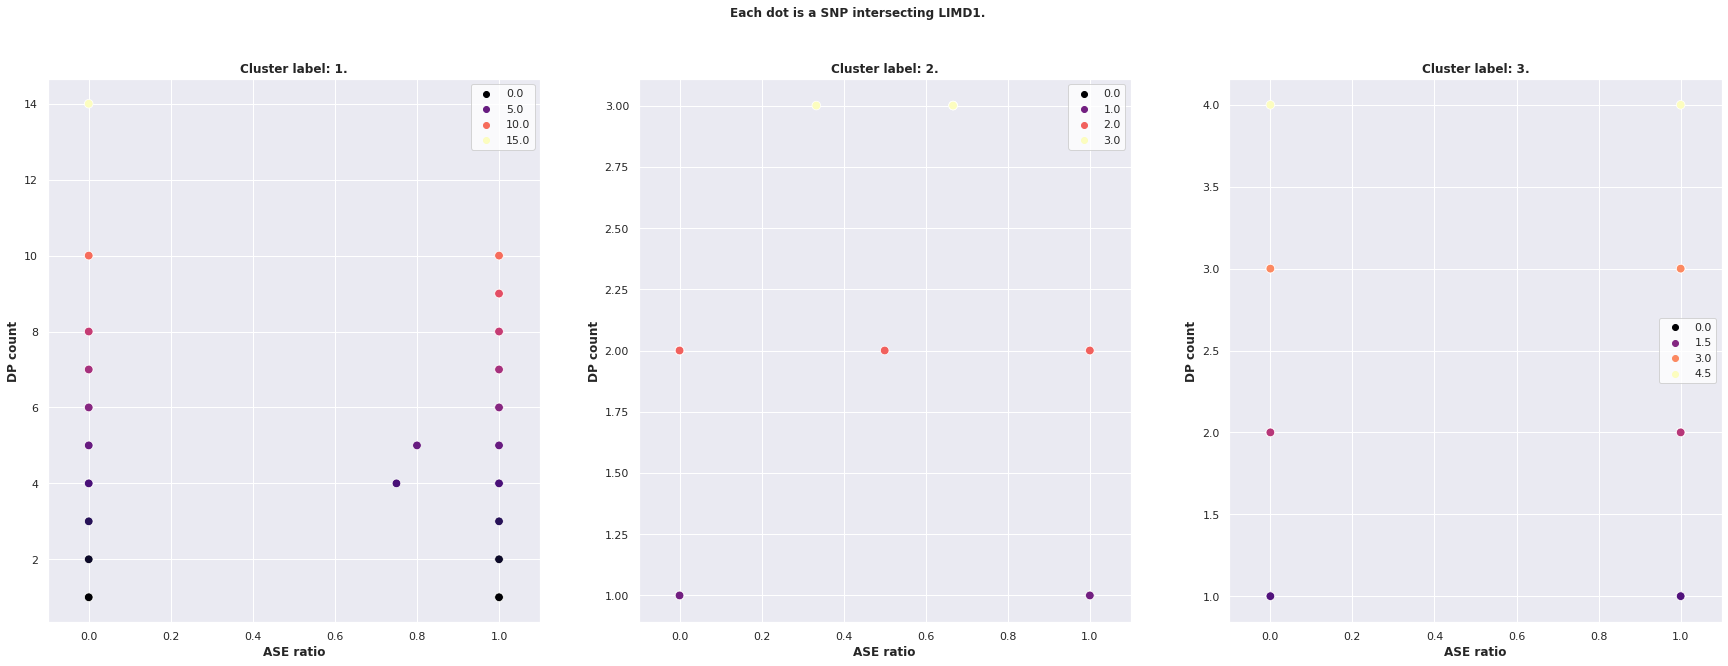

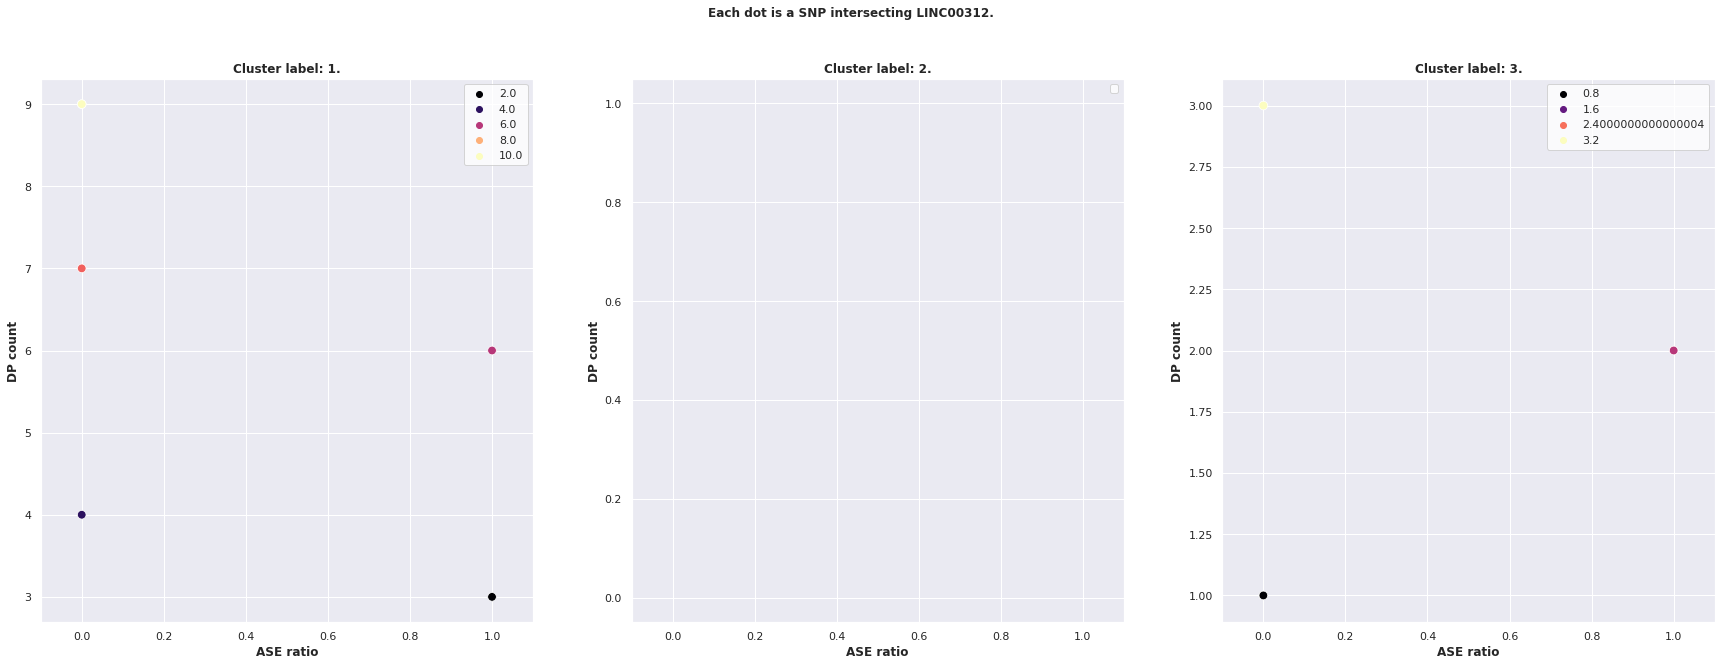

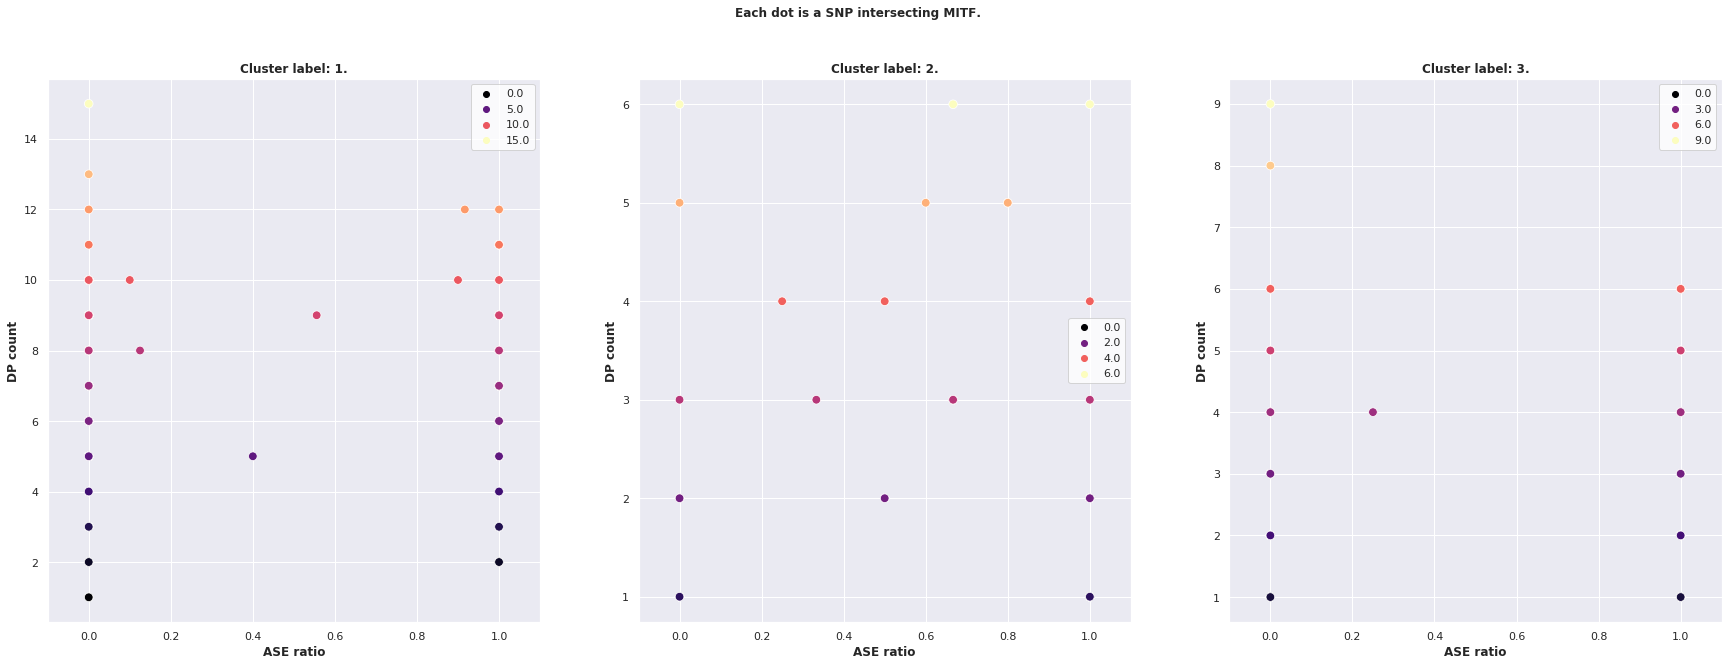

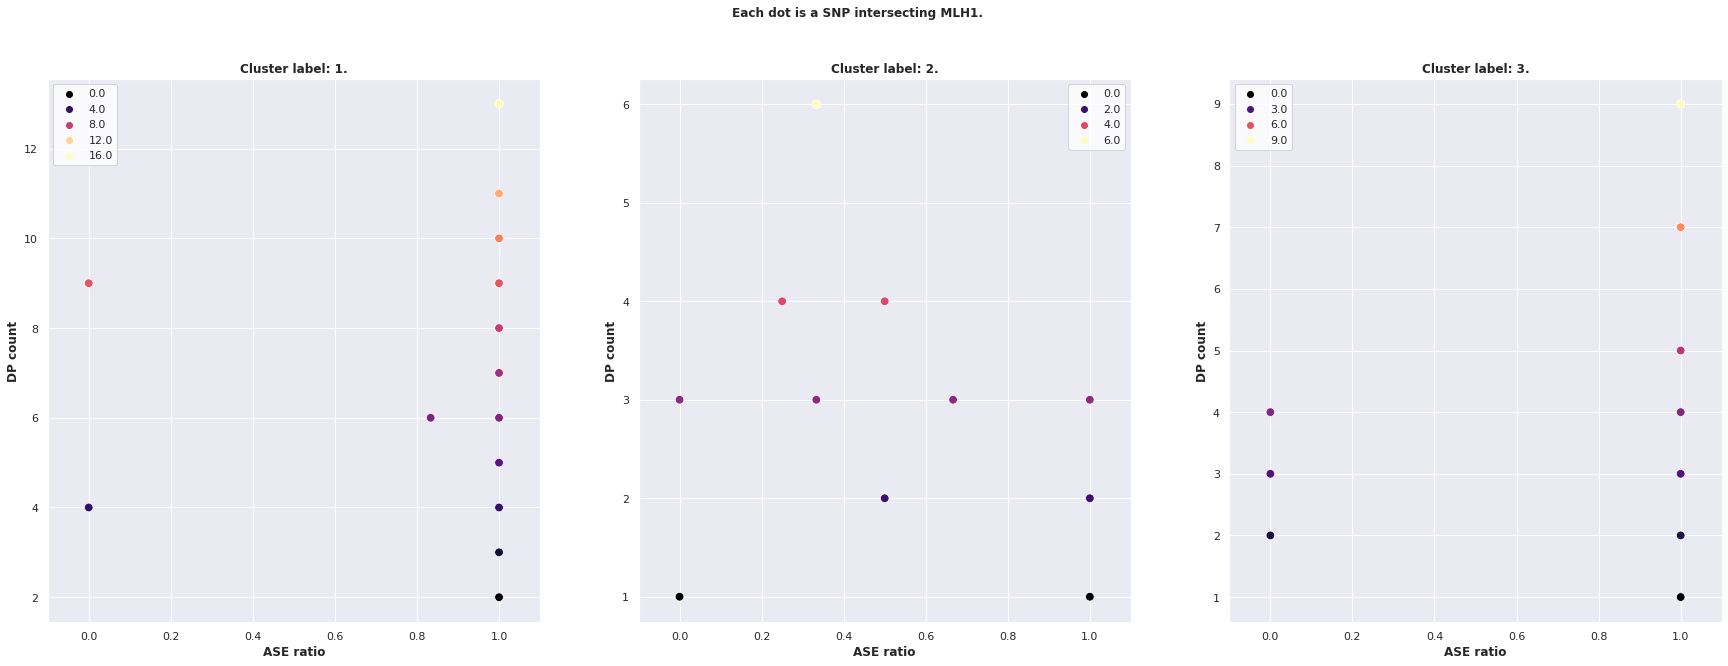

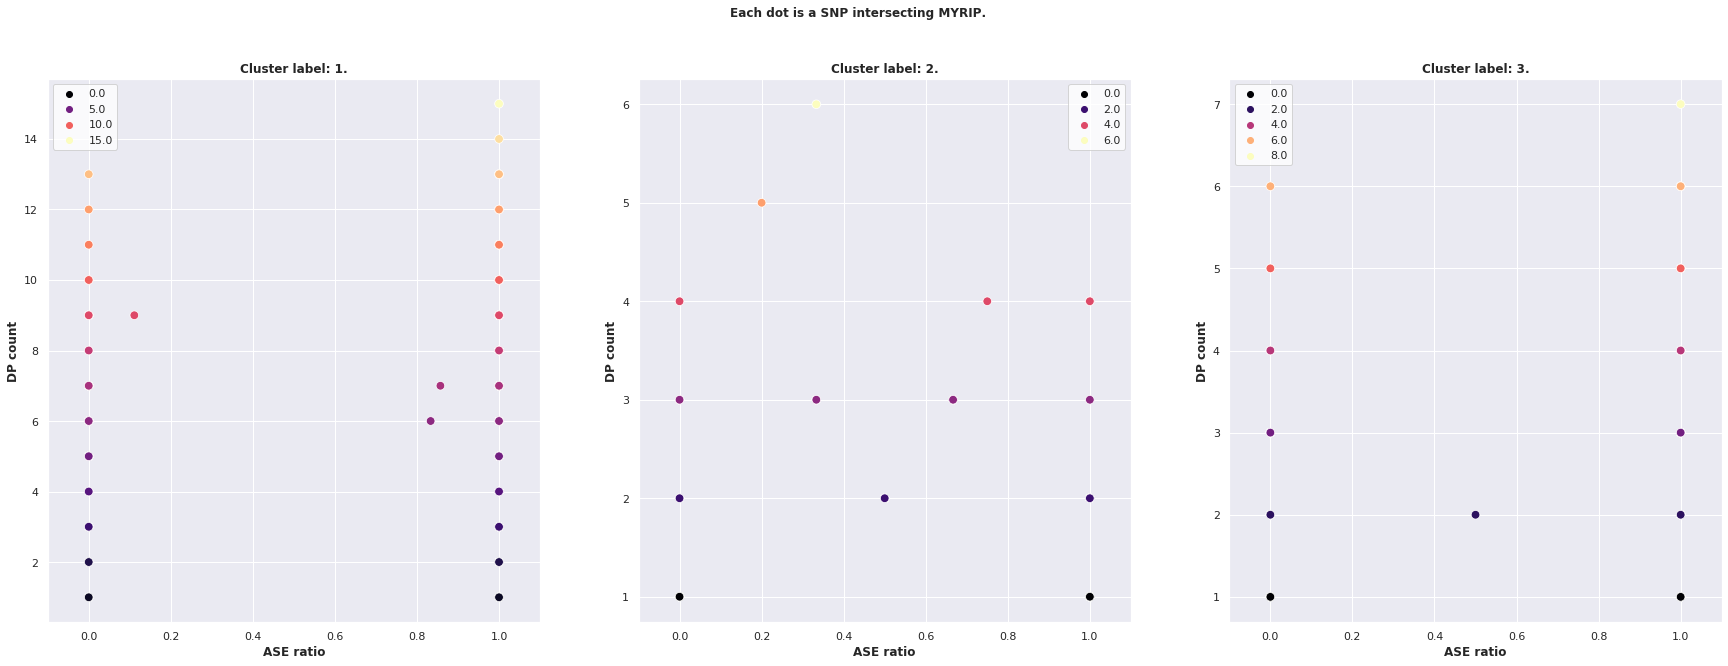

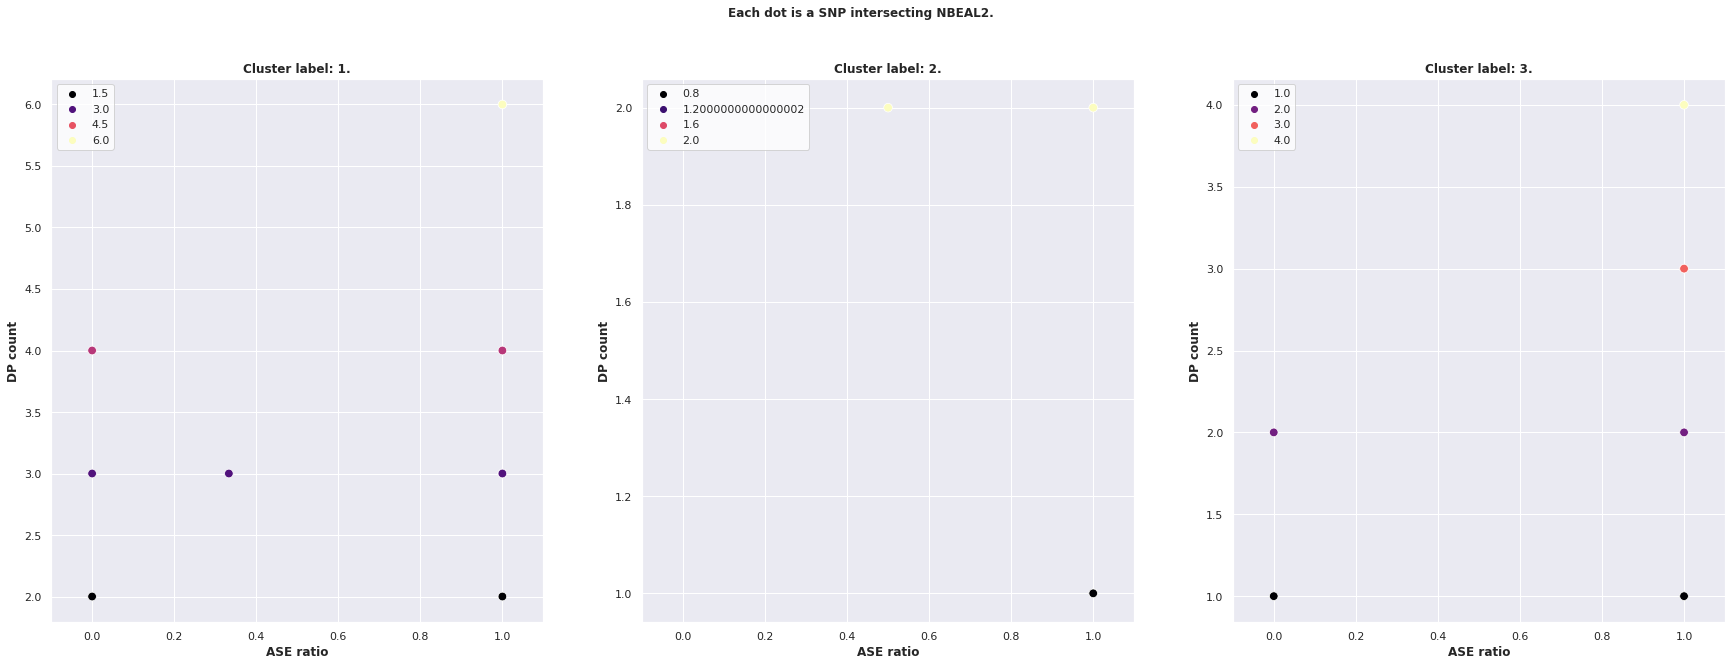

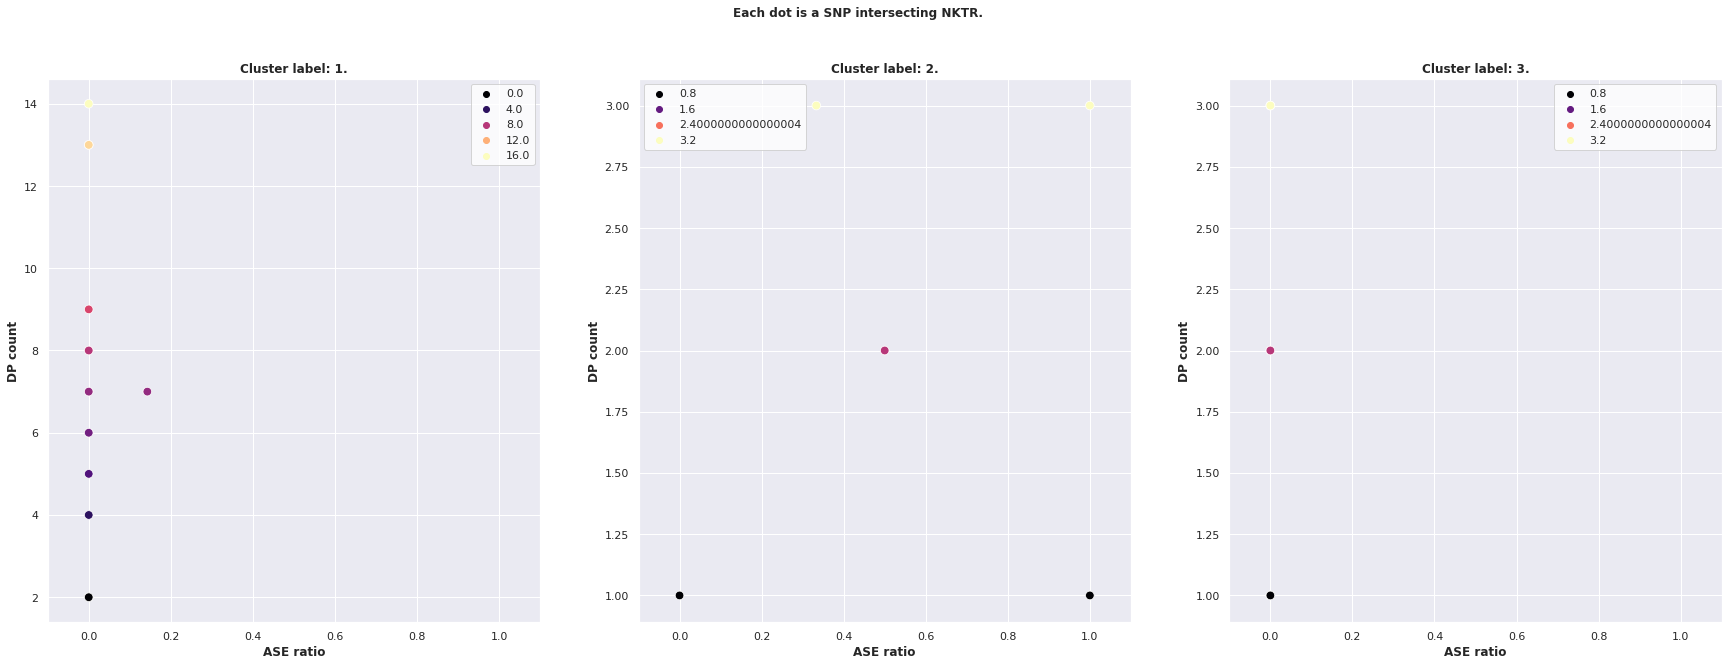

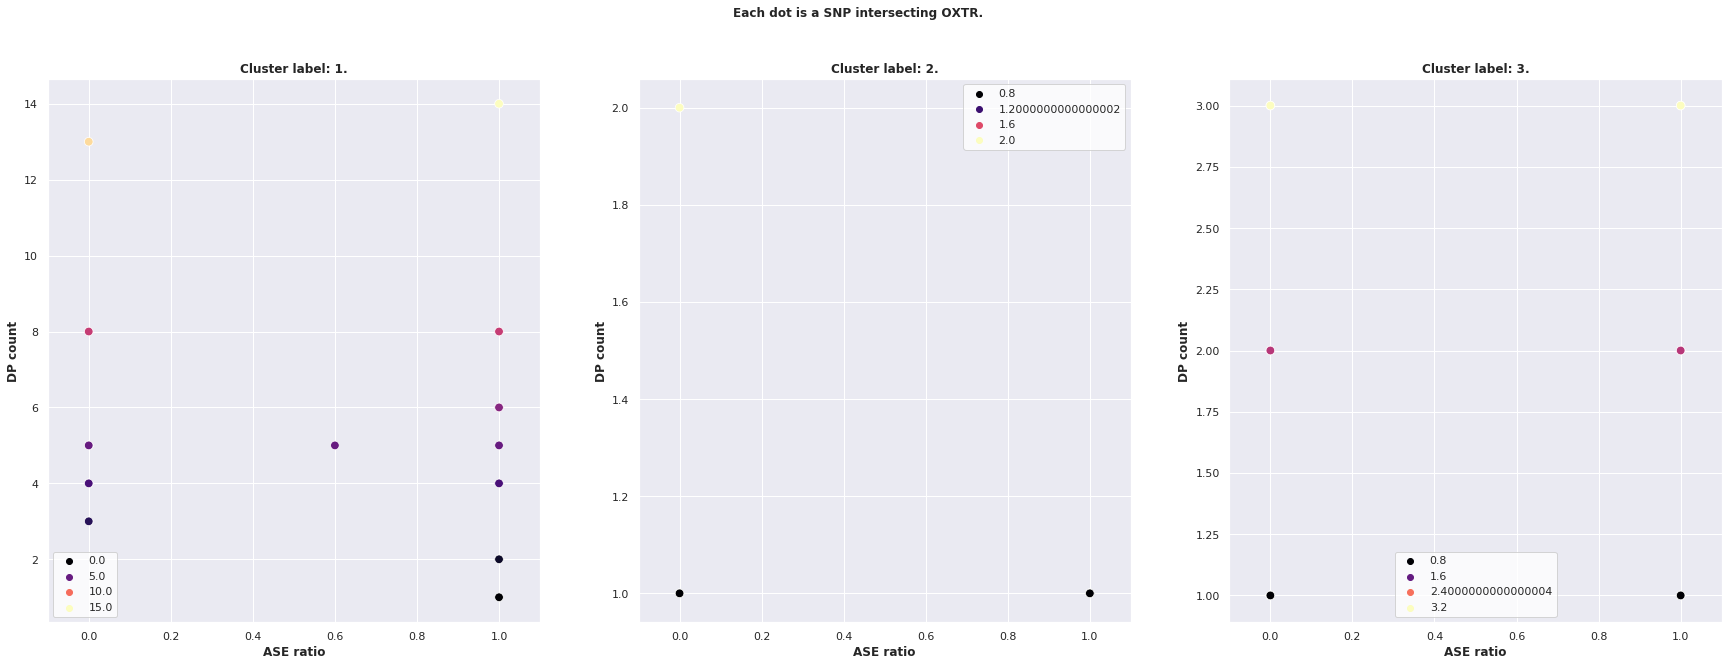

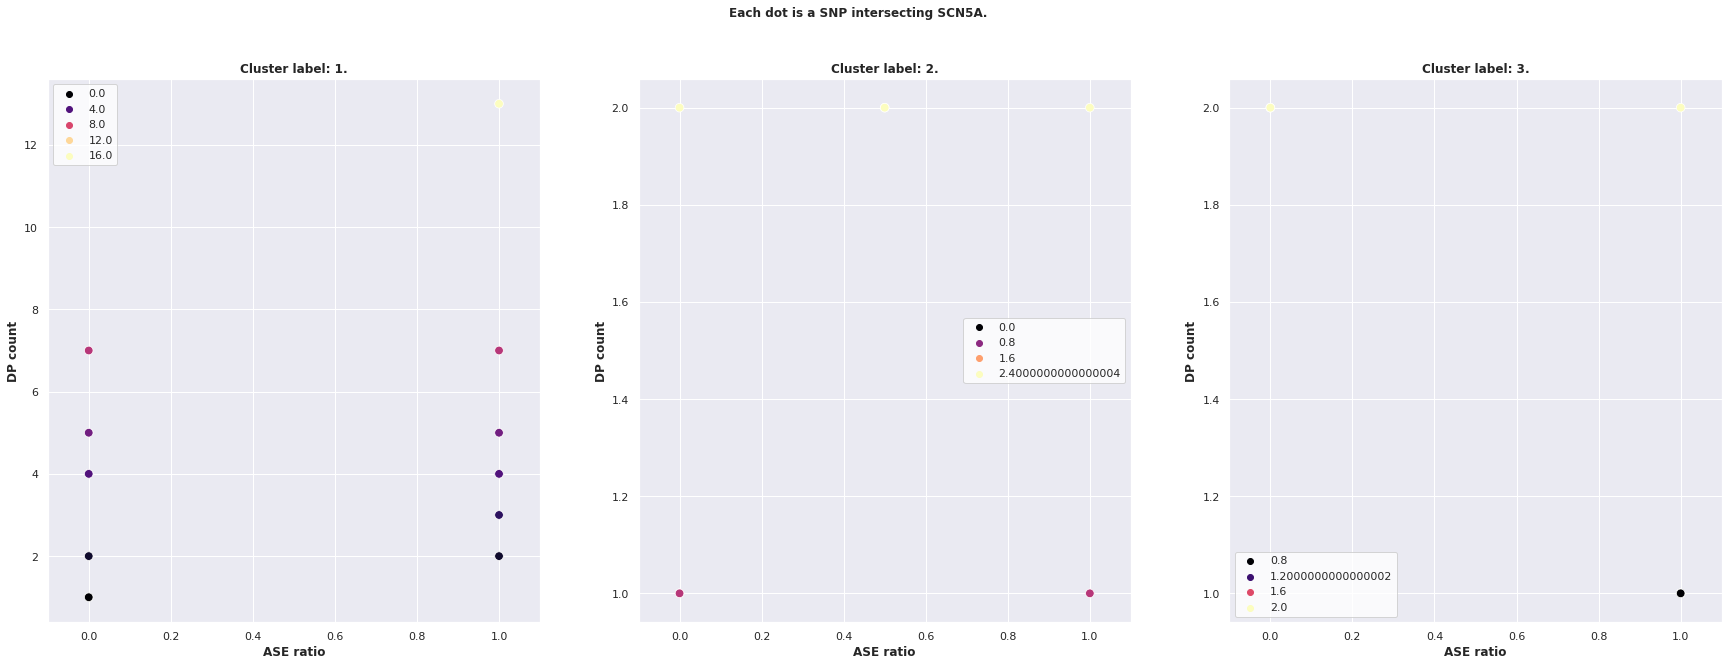

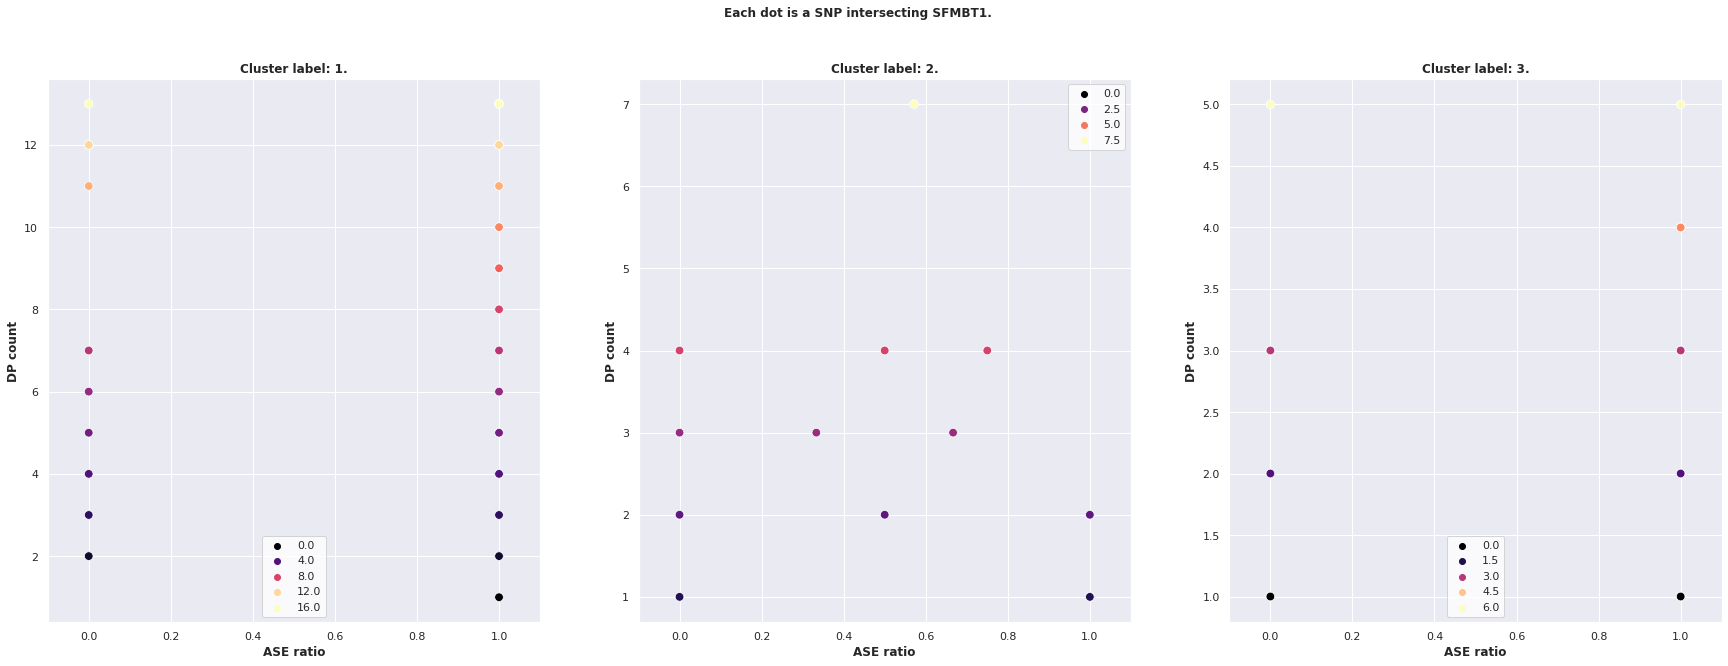

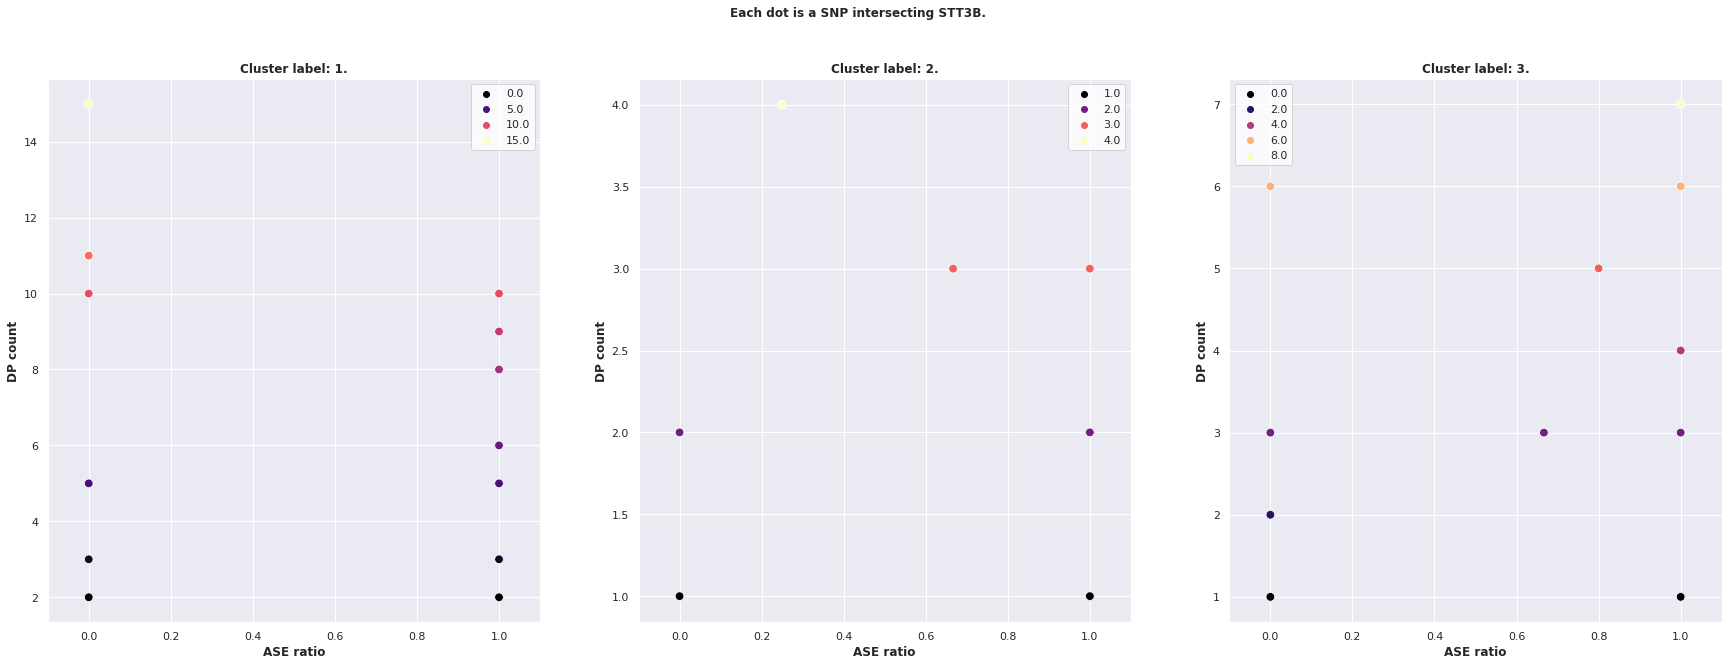

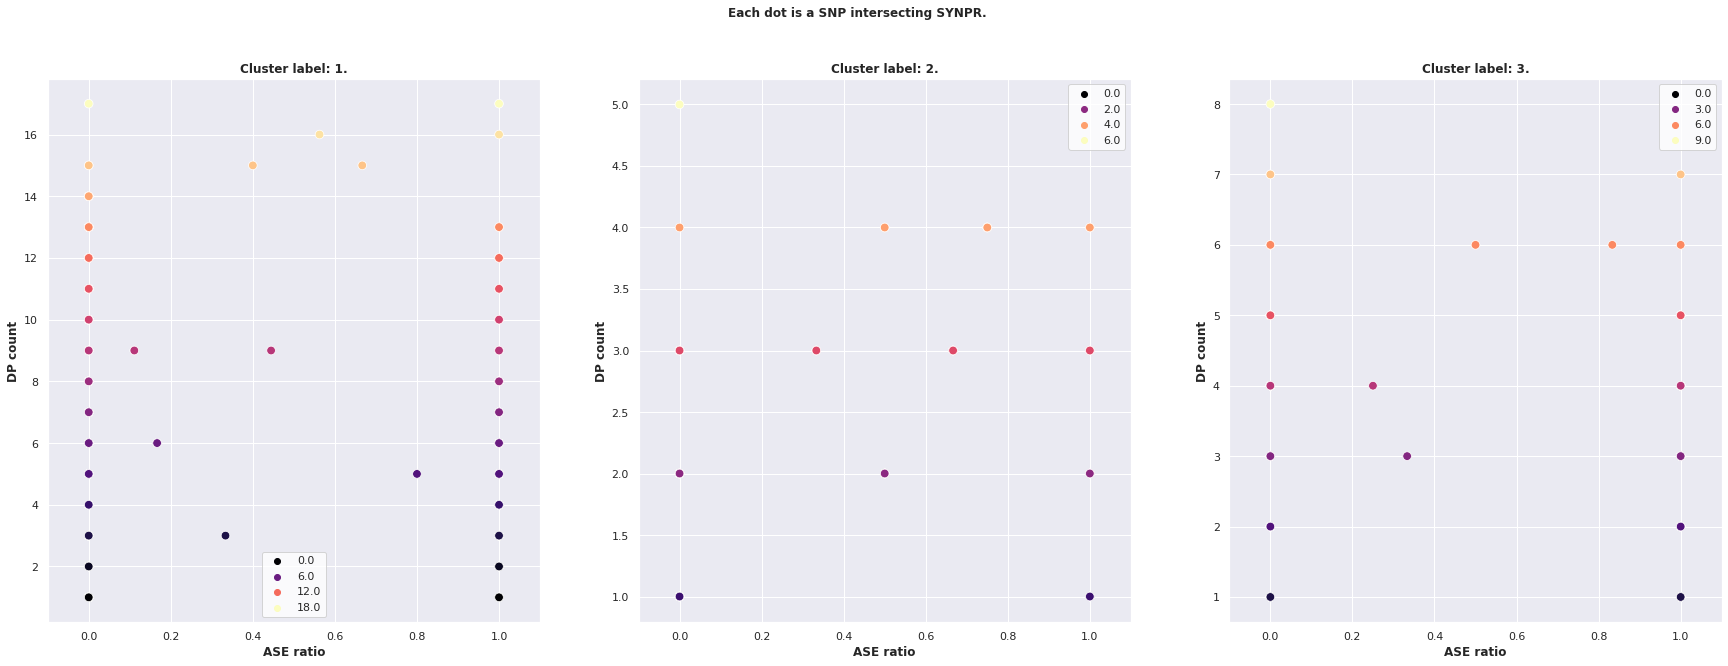

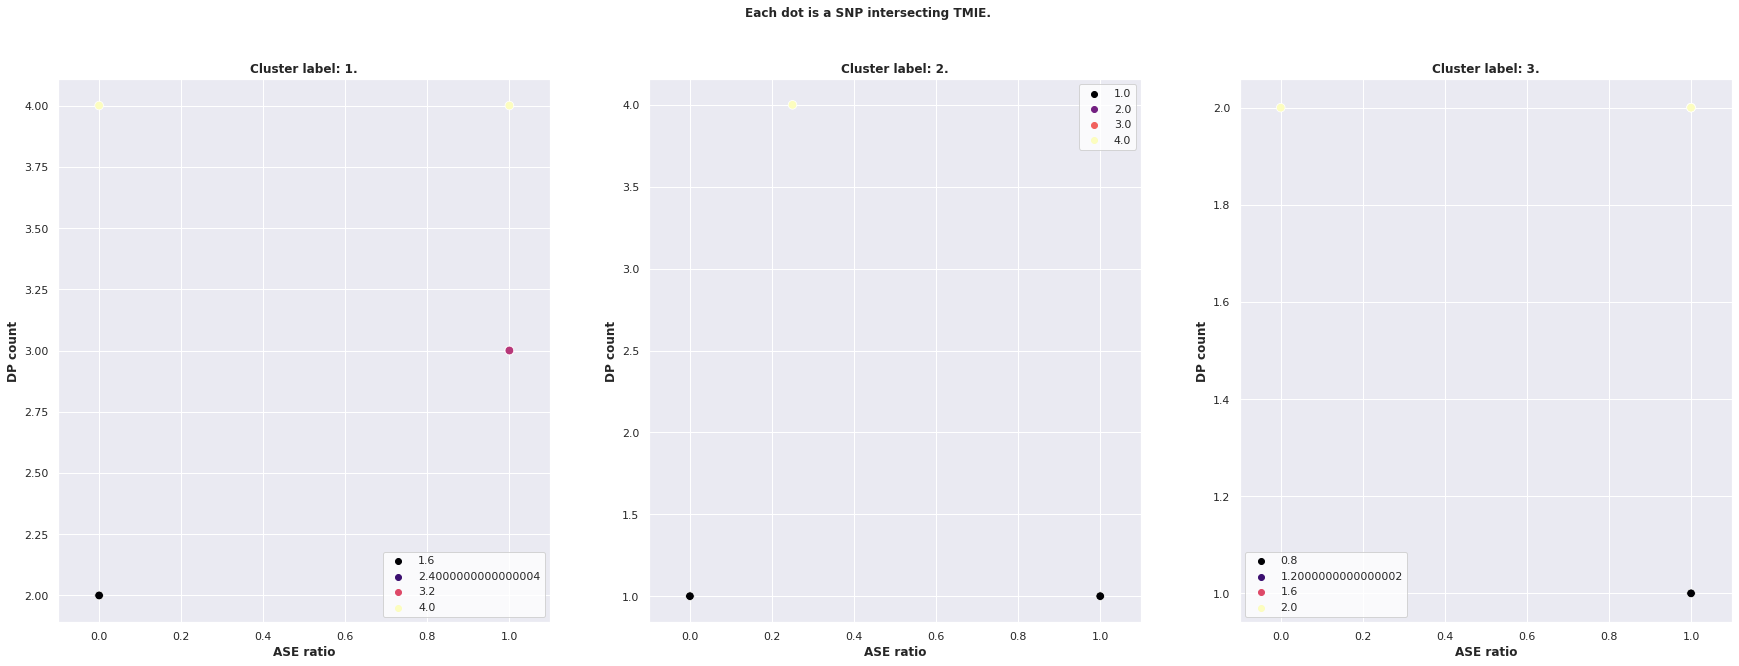

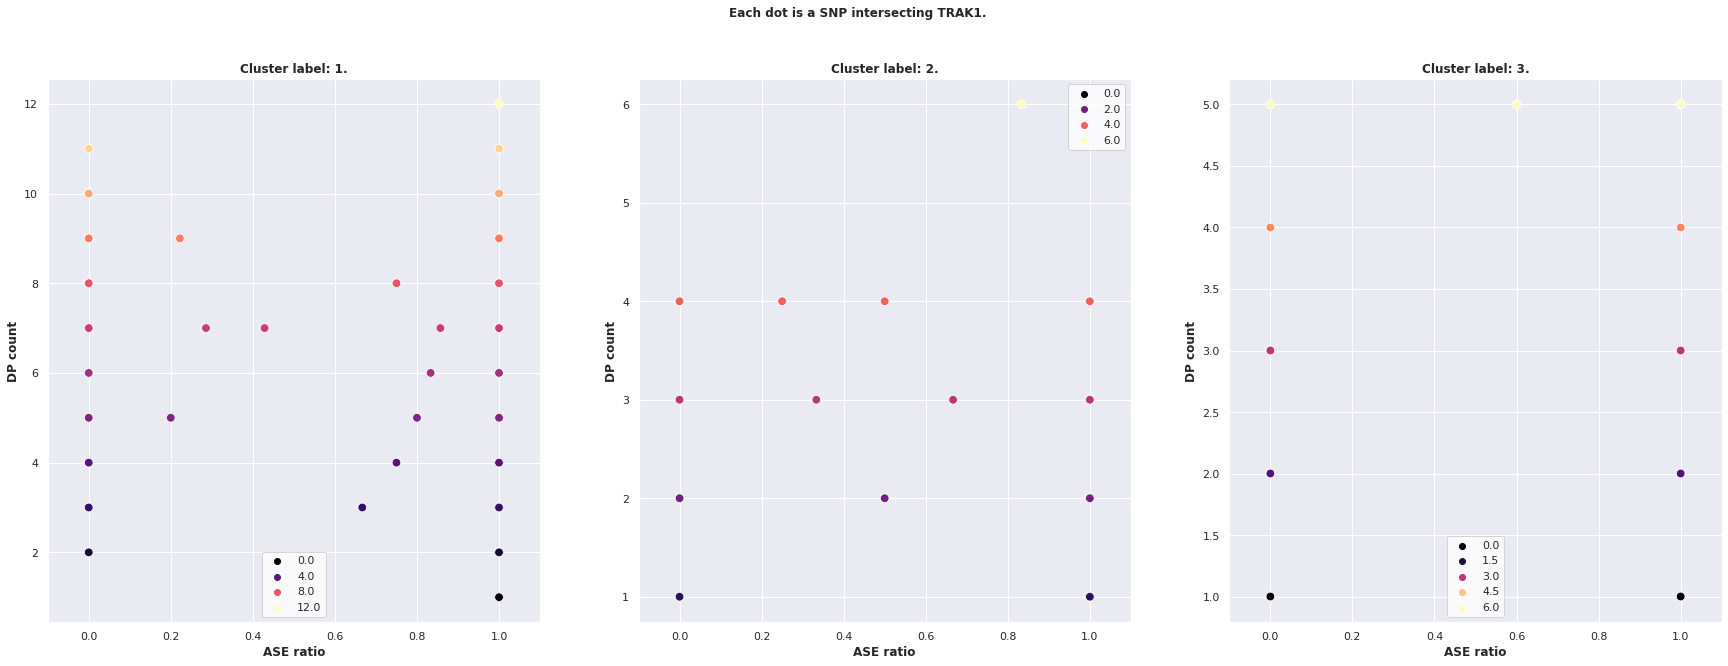

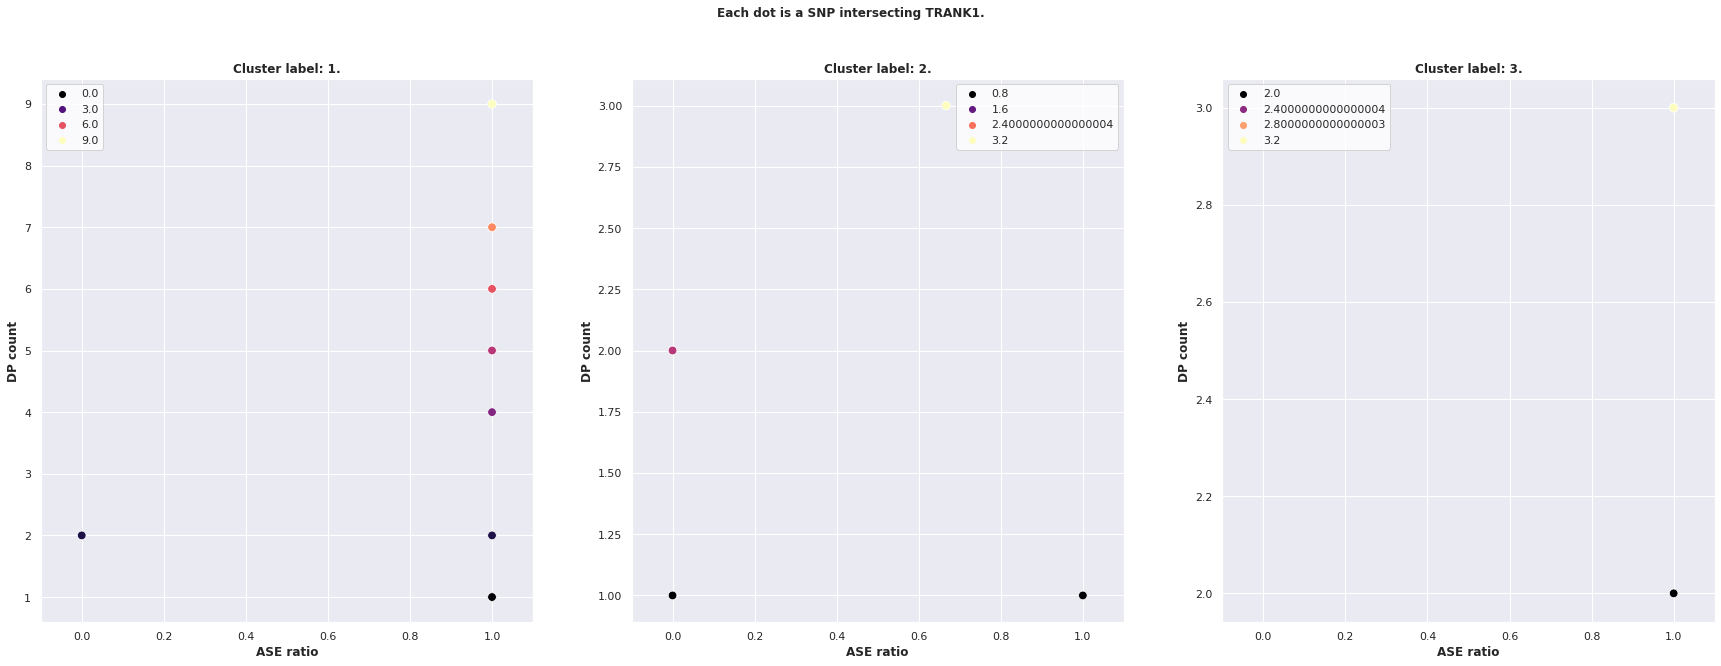

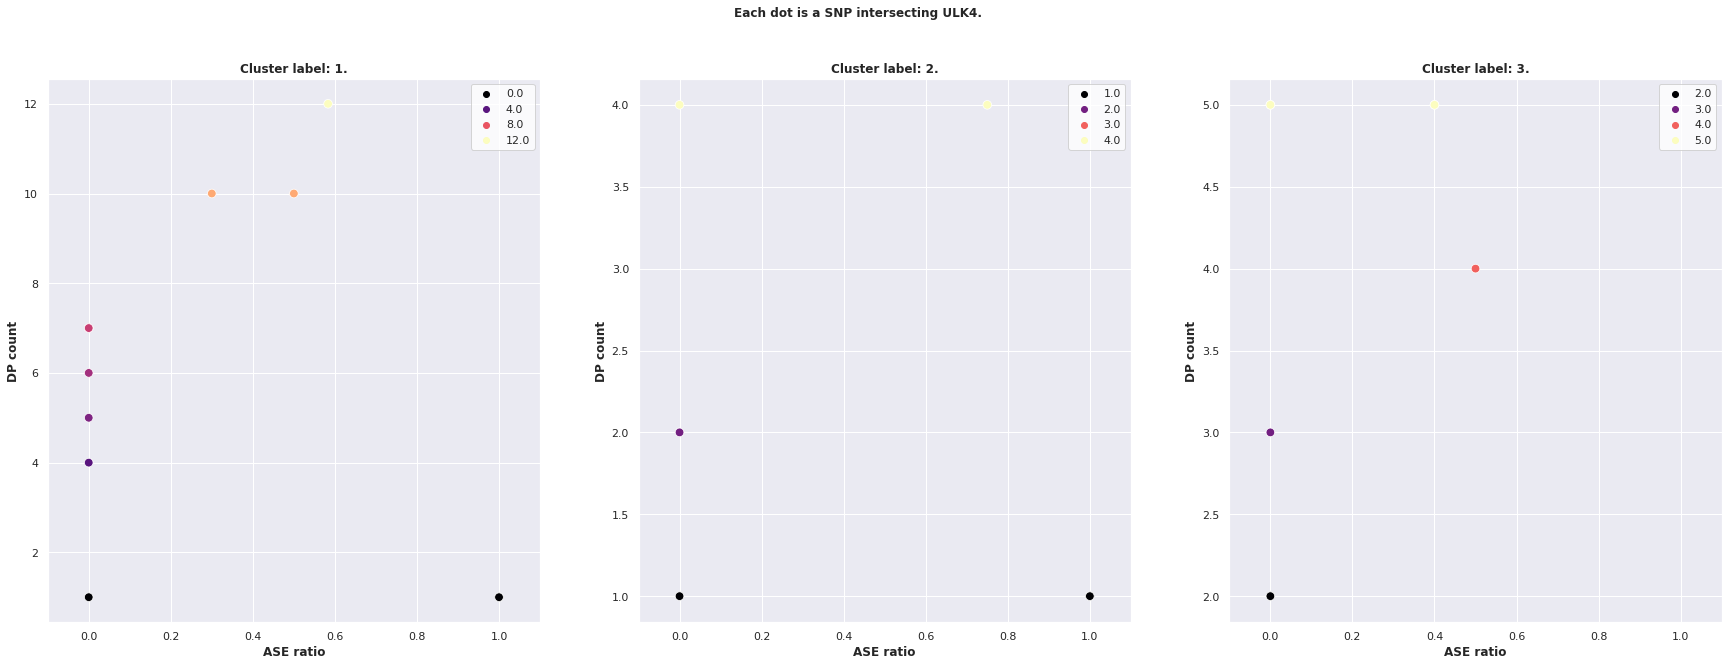

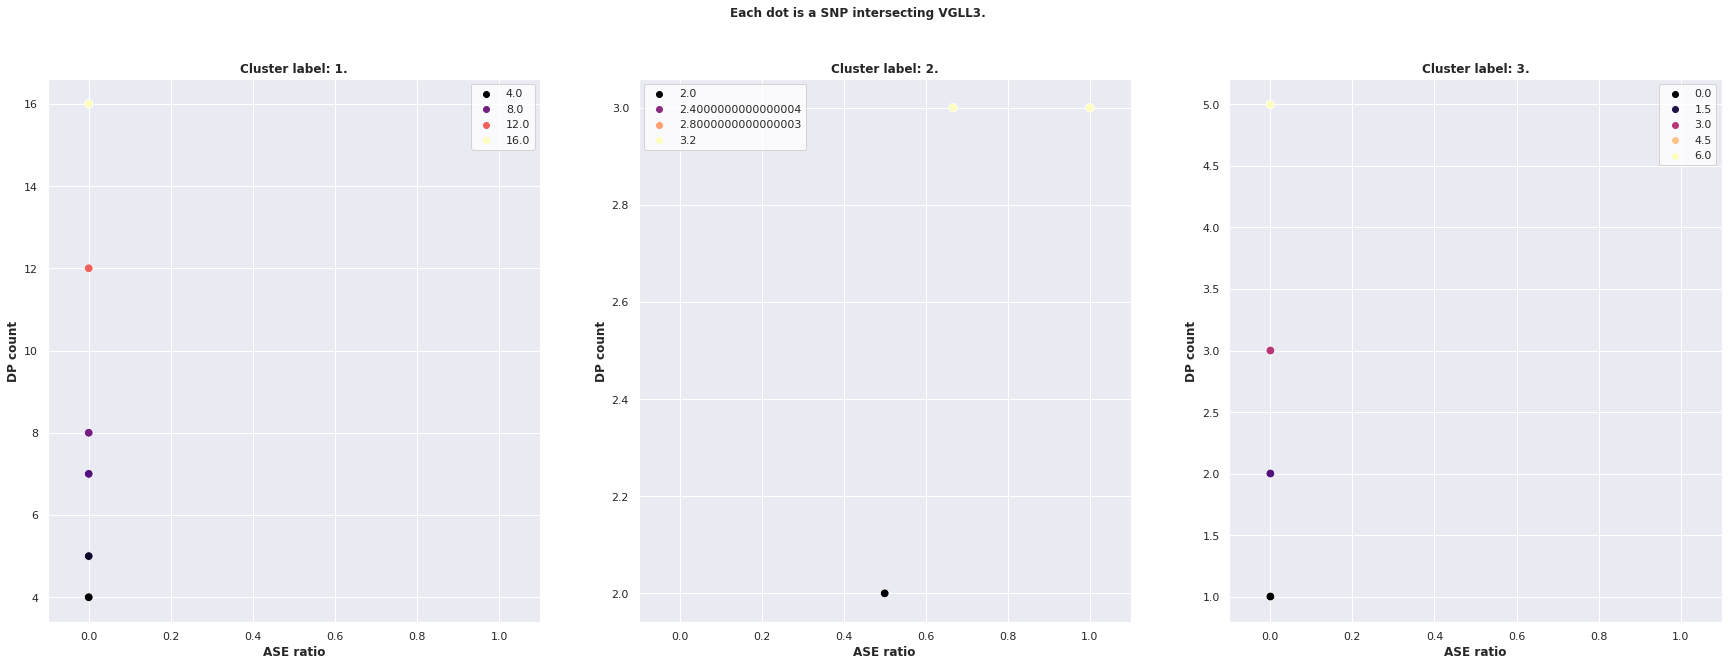

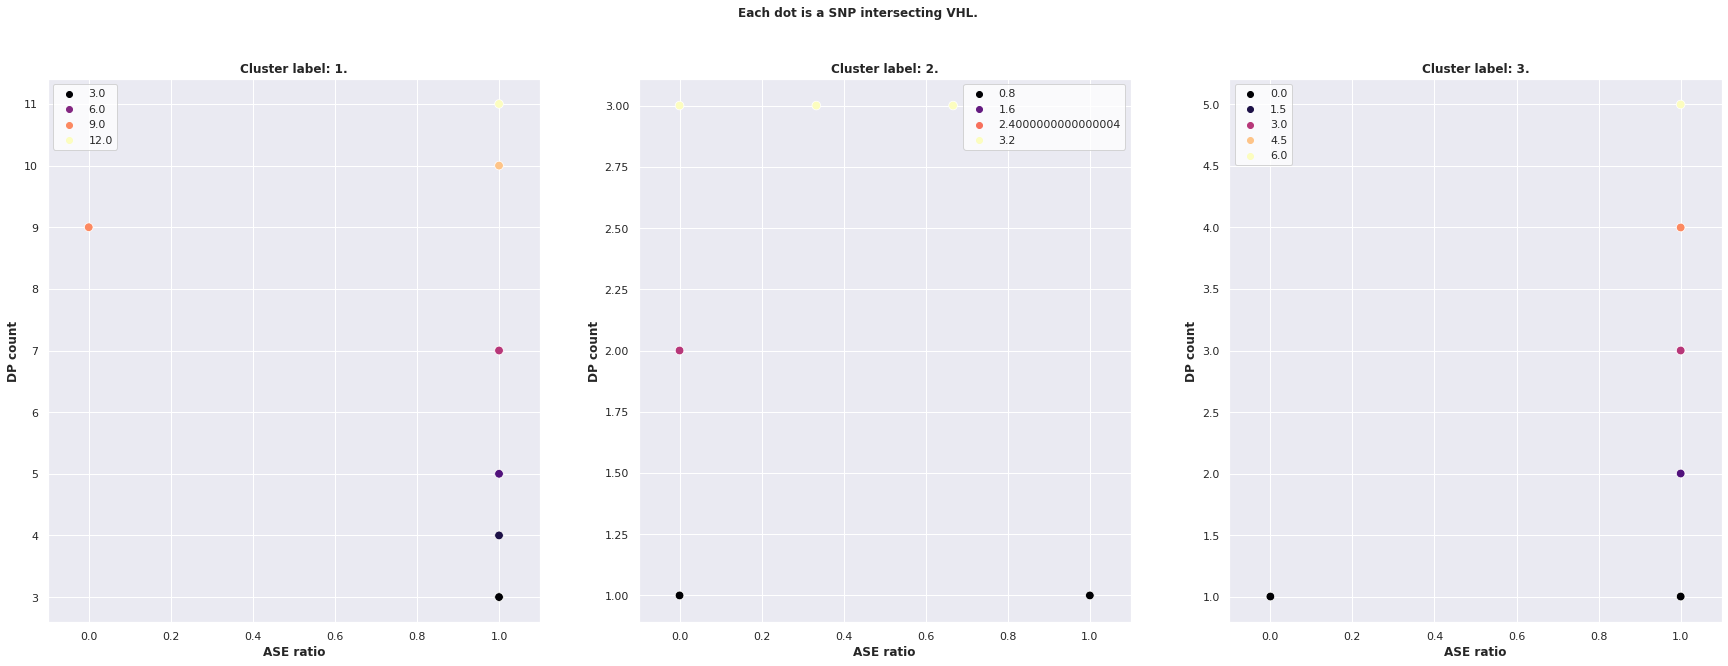

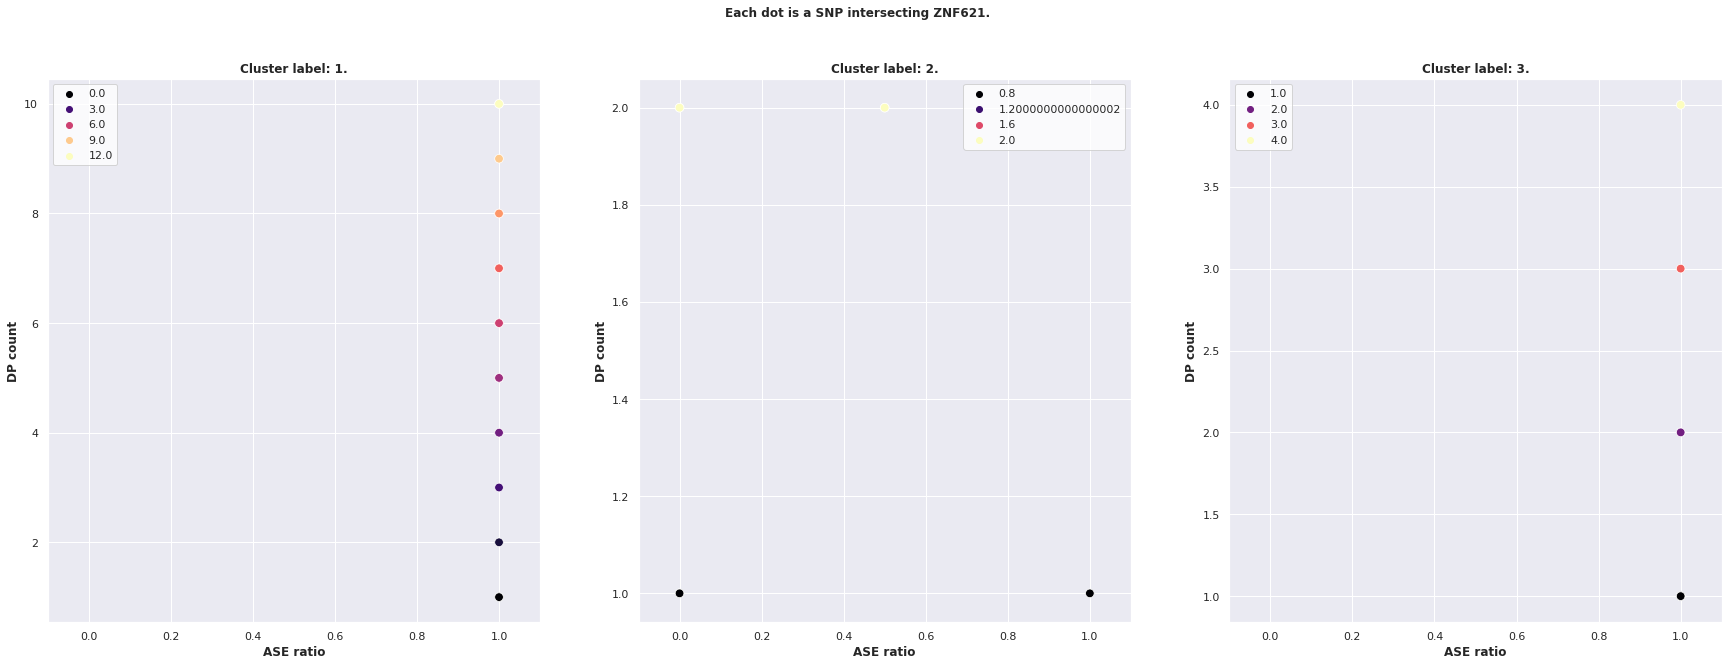

In [22]:
test_phasing.test_deletion_ase_for_snps(genes_on_3p, data)

# Clustermaps depicting present-to-missing ratio

In [ ]:
%%time
sys.setrecursionlimit(int(1e6))
sns.clustermap(
    toolkit.extract_counts(data["block_counts"], "dp")\
    .iloc[:, :500].fillna(0) > 0,
    row_cluster=False
)

In [ ]:
%%time
sys.setrecursionlimit(int(1e6))
sns.clustermap(
    toolkit.extract_counts(data["block_counts"], "dp")\
    .iloc[:, :500].fillna(0) > 0,
    row_cluster=True
)

# Overall count depth analysis

In [3]:
total_dp_counts = np.zeros(data["counts"].shape[0])
for barcode in tqdm(
    toolkit.extract_barcodes(data["counts"]),
    "processing barcodes"
):
    total_dp_counts += data["counts"]\
                        [f"{barcode}_dp"]\
                        .to_dense()\
                        .fillna(0)\
                        .values

processing barcodes: 100%|██████████| 268/268 [00:06<00:00, 41.83it/s]


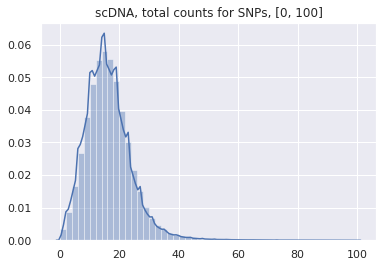

In [11]:
plt.title(f"{nb_config['experiment_info']['data']}"
          ", total counts for SNPs, [0, 100]")
sns.distplot(total_dp_counts[total_dp_counts <= 100]);

In [5]:
summary_df = pd.DataFrame(total_dp_counts)\
.describe(percentiles=np.arange(0,1,0.05))\
.astype(int).T
summary_df

,count,mean,std,min,0%,5%,10%,15%,20%,25%,...,55%,60%,65%,70%,75%,80%,85%,90%,95%,max
0,1552849,16,38,0,0,5,7,9,10,11,...,16,17,18,19,20,22,23,26,30,29898


In [6]:
quantile = "75%"

In [7]:
above_quantile = [
    f"{chrom},{pos}" for chrom, pos 
    in data["counts"][["CHROM", "POS"]]\
        [total_dp_counts >= summary_df[quantile].values]\
        .values\
        .astype(int)
]

In [17]:
snp_in_gene_mask = np.array([len(data["snp_to_genes"][snp]) >= 1 
                             for snp in above_quantile])
print(
    "{:.2f}% ({} out of {}) of SNPs with non-zero count depth intersect genes"
    " \nand have more than 30 (95% percentile) reads mapped"\
    .format( 
        100 * np.mean(snp_in_gene_mask),
        np.sum(snp_in_gene_mask), snp_in_gene_mask.size
    )
)

47.44% (209143 out of 440895) of SNPs with non-zero count depth intersect genes 
and have more than 30 (95% percentile) reads mapped


In [21]:
gene_to_snp_counts_ratio = (
    toolkit.extract_counts(data["counts"], suffix="dp").sum()
    / toolkit.extract_counts(data["gene_counts"], suffix="dp").sum()
)

(array([  1.,   0.,   2.,   3.,  30., 128.,  69.,  24.,   6.,   5.]),
 array([0.44784933, 0.45360587, 0.45936241, 0.46511895, 0.47087549,
        0.47663203, 0.48238857, 0.48814511, 0.49390165, 0.49965819,
        0.50541473]),
 <a list of 10 Patch objects>)

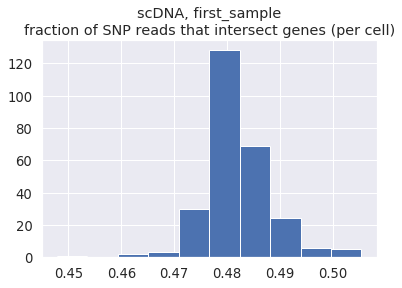

In [35]:
plt.title(f"{data_name}, {sample_name}\n"
          "fraction of SNP reads that intersect blocks (per cell)")
plt.hist(1 / gene_to_snp_counts_ratio)

537 columns, 268 barcodes, 15819 genes


/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/lib/plotlib.py:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


CPU times: user 570 ms, sys: 92.8 ms, total: 663 ms
Wall time: 657 ms


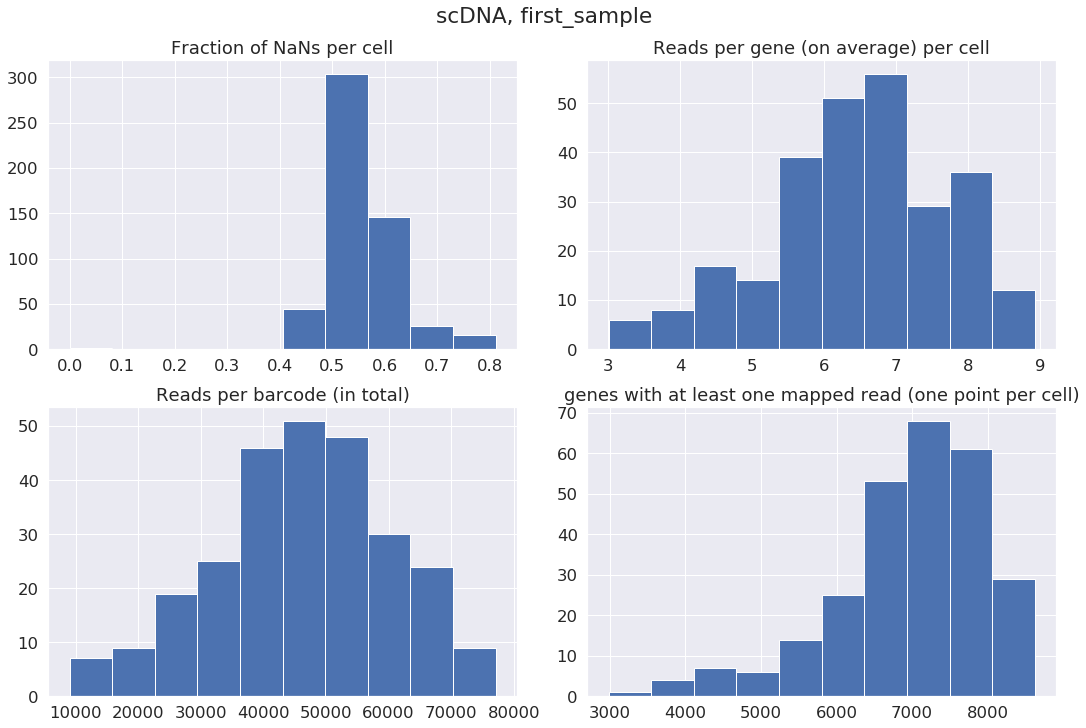

In [36]:
%%time
sns.set(font_scale=1.5)
plotlib.describe_read_counts(
    data["gene_counts"], 
    f"{data_name}, {sample_name}", 
    feature_name="gene"
)

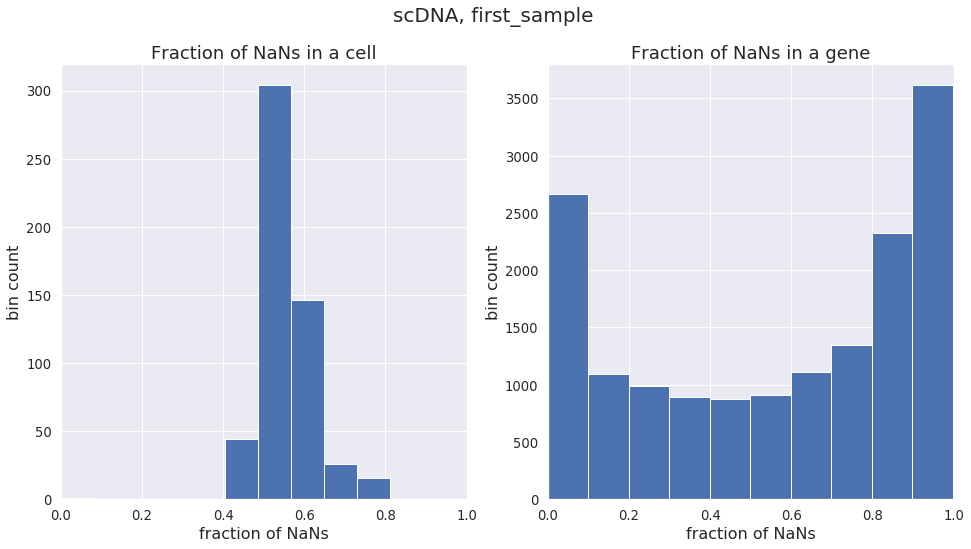

In [32]:
util.nan_fraction(
    data["block_counts"], 
    axis_list=[0, 1],
    suptitle=f"{data_name}, {sample_name}",
    verbose=False,
    show_plots=True,
    axis_to_name={1 : "gene", 0 : "cell"},
    outfile=f"{nb_config['img_dir']['sample']}/nan_fraction.pdf"
);